# Zeitbezogene Analysen

Das studentische Verhalten wird nachfolgend in zeitlicher Hinsicht betrachtet.

**Zeitraum der aufgezeichneten Log-Einträge**
Montag, 12.10.2020 bis Donnerstag, 03.06.2021
Länge des Zeitraums: 7 Monate, 3 Wochen, 2 Tage
Länge in Tagen: 235 Tage
Länge in Wochen: 33 Wochen, 4 Tage

**Prüfungszeitraum 1**
Freitag, 22.01.2021 bis Samstag, 06.02.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

**Prüfungszeitraum 2**
Freitag, 12.03.2021 bis Samstag, 27.03.2021
Länge in Tagen: 16 Tage (inkl. Sonntage)

### Import von Bibliotheken und anderen Erweiterungen

In [10715]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
from matplotlib import patches as mpatches
import seaborn as sns
from IPython.core.display_functions import display

### Definitionen zur Darstellung der Visualisierungen

In [10716]:
sns.set_theme(style='white', font_scale=1.2, palette='Set2_r')

# Definition einer Liste von Farben für Gesamtbetrachtungen (Brewer-Palette 'Paired')
colors_general = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']

# Definition einer Liste von Farben für die Studiengänge
colors_studies = ['#dac29e', '#e5c94a', '#a2c865', '#da96bf', '#94a3c2']

### Herstellung der Verbindung zur MySQL-Datenbank

In [10717]:
user = "root"
password = "root"
host = "localhost"
database = "vfh_moodle_ws20"
port = 3306

engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}', pool_recycle=port)
connection = engine.connect()

### Selektiver Import der Arbeitsdaten aus der MySQL-Datenbank

**Begrenzung der Selektion auf Studenten**

In [10718]:
# Gegenstand der Untersuchungen sind nur Datensätze von Benutzern, die zuvor als Studenten identifiziert wurden – unabhängig davon,
# ob diese selbst eine Aktivität initiiert haben oder nur mit einer Aktivität einer anderen Person in Beziehung standen.
query = """SELECT * FROM moodle_data WHERE userstatus = 'student' OR relateduserstatus = 'student'"""
moodle_data = pd.read_sql(query, connection) # Definition der Arbeitsdaten

# Konvertierung des Datentyps des Tabellenmerkmals timecreated
moodle_data['timecreated'] = pd.to_datetime(moodle_data['timecreated'], unit='s')

# Ergänzung weiterer Merkmale zur Betrachtung zeitlicher Aspekte
moodle_data['year_month'] = moodle_data['timecreated'].dt.strftime('%Y-%m')
moodle_data['year_week'] = moodle_data['timecreated'].dt.strftime('%Y-%U')
# zur Unterscheidung von Arbeitstagen und Wochenenden
moodle_data['daytype'] = 'workingday'
moodle_data.loc[moodle_data.timecreated.dt.dayofweek > 4, ['daytype']] = 'weekend'
# zur Unterscheidung von Tageszeiten
moodle_data['daytime'] = 'night'
moodle_data.loc[(moodle_data.timecreated.dt.hour >= 6) & (moodle_data.timecreated.dt.hour < 14), ['daytime']] = 'morning'
moodle_data.loc[(moodle_data.timecreated.dt.hour >= 14) & (moodle_data.timecreated.dt.hour < 18), ['daytime']] = 'afternoon'
moodle_data.loc[(moodle_data.timecreated.dt.hour >= 18) & (moodle_data.timecreated.dt.hour < 22), ['daytime']] = 'evening'
# zur Unterscheidung von Semesterabschnitten
moodle_data['semesterperiod'] = 'before_exams'
moodle_data.loc[(moodle_data.timecreated > pd.to_datetime('2021-01-22')) & (moodle_data.timecreated < pd.to_datetime('2021-02-07')), ['semesterperiod']] = 'exams1'
moodle_data.loc[(moodle_data.timecreated > pd.to_datetime('2021-02-07')) & (moodle_data.timecreated < pd.to_datetime('2021-03-12')), ['semesterperiod']] = 'between_exams'
moodle_data.loc[(moodle_data.timecreated > pd.to_datetime('2021-03-12')) & (moodle_data.timecreated < pd.to_datetime('2021-03-28')), ['semesterperiod']] = 'exams2'
moodle_data.loc[moodle_data.timecreated > pd.to_datetime('2021-03-28'), ['semesterperiod']] = 'after_exams'

# Ausgabe der Arbeitsdaten
moodle_data

,courseid,Studiengang,userid,userstatus,relateduserid,relateduserstatus,action,eventname,objecttable,objectid,timecreated,course_module_type,instanceid,year_month,year_week,daytype,daytime,semesterperiod
0,0,0,1,student,-2,other,sent,\core\event\notification_sent,notifications,3232247,2020-10-12 04:54:03,,0,2020-10,2020-41,workingday,night,before_exams
1,629,1,13,student,-2,other,viewed,\core\event\user_profile_viewed,user,3837,2020-10-17 09:00:11,,0,2020-10,2020-41,weekend,morning,before_exams
2,0,0,-2,other,24,student,sent,\core\event\notification_sent,notifications,3281851,2020-10-18 14:27:05,,0,2020-10,2020-42,weekend,afternoon,before_exams
3,0,0,-2,other,1,student,sent,\core\event\notification_sent,notifications,3281852,2020-10-18 14:27:05,,0,2020-10,2020-42,weekend,afternoon,before_exams
4,0,0,1,student,-2,other,sent,\core\event\notification_sent,notifications,3290921,2020-10-19 15:54:03,,0,2020-10,2020-42,workingday,afternoon,before_exams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333768,28512,3,109,student,109,student,deleted,\mod_forum\event\discussion_subscription_deleted,forum_discussion_subs,45244,2021-06-03 21:11:35,,0,2021-06,2021-22,workingday,evening,after_exams
333769,28512,3,109,student,0,none,viewed,\core\event\course_viewed,,0,2021-06-03 21:12:09,,0,2021-06,2021-22,workingday,evening,after_exams
333770,0,0,109,student,109,student,viewed,\core\event\dashboard_viewed,,0,2021-06-03 21:13:25,,0,2021-06,2021-22,workingday,evening,after_exams
333771,28514,3,109,student,0,none,viewed,\core\event\course_viewed,,0,2021-06-03 21:13:36,,0,2021-06,2021-22,workingday,evening,after_exams


**Begrenzung der Selektion auf studentische Aktivitäten mit Personenbezug**

In [10719]:
# Auswahl der Datensätze mit Personenbezug
moodle_data_related = moodle_data[moodle_data.relateduserstatus != 'none']
moodle_data_related

,courseid,Studiengang,userid,userstatus,relateduserid,relateduserstatus,action,eventname,objecttable,objectid,timecreated,course_module_type,instanceid,year_month,year_week,daytype,daytime,semesterperiod
0,0,0,1,student,-2,other,sent,\core\event\notification_sent,notifications,3232247,2020-10-12 04:54:03,,0,2020-10,2020-41,workingday,night,before_exams
1,629,1,13,student,-2,other,viewed,\core\event\user_profile_viewed,user,3837,2020-10-17 09:00:11,,0,2020-10,2020-41,weekend,morning,before_exams
2,0,0,-2,other,24,student,sent,\core\event\notification_sent,notifications,3281851,2020-10-18 14:27:05,,0,2020-10,2020-42,weekend,afternoon,before_exams
3,0,0,-2,other,1,student,sent,\core\event\notification_sent,notifications,3281852,2020-10-18 14:27:05,,0,2020-10,2020-42,weekend,afternoon,before_exams
4,0,0,1,student,-2,other,sent,\core\event\notification_sent,notifications,3290921,2020-10-19 15:54:03,,0,2020-10,2020-42,workingday,afternoon,before_exams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333759,28512,3,109,student,109,student,updated,\core\event\course_module_completion_updated,course_modules_completion,74802,2021-06-03 20:16:13,,0,2021-06,2021-22,workingday,evening,after_exams
333761,0,0,109,student,109,student,viewed,\core\event\dashboard_viewed,,0,2021-06-03 20:37:02,,0,2021-06,2021-22,workingday,evening,after_exams
333766,28512,3,109,student,109,student,created,\mod_forum\event\discussion_subscription_created,forum_discussion_subs,45244,2021-06-03 21:11:23,,0,2021-06,2021-22,workingday,evening,after_exams
333768,28512,3,109,student,109,student,deleted,\mod_forum\event\discussion_subscription_deleted,forum_discussion_subs,45244,2021-06-03 21:11:35,,0,2021-06,2021-22,workingday,evening,after_exams


**Begrenzung der Selektion auf studentische Aktivitäten ohne Personenbezug**

In [10720]:
# Auswahl der Datensätze ohne Personenbezug
moodle_data_not_related = moodle_data[moodle_data.relateduserstatus == 'none']
moodle_data_not_related

,courseid,Studiengang,userid,userstatus,relateduserid,relateduserstatus,action,eventname,objecttable,objectid,timecreated,course_module_type,instanceid,year_month,year_week,daytype,daytime,semesterperiod
710,0,0,60,student,0,none,loggedin,\core\event\user_loggedin,user,16741,2020-10-28 14:19:17,,0,2020-10,2020-43,workingday,afternoon,before_exams
712,0,0,60,student,0,none,loggedout,\core\event\user_loggedout,user,16741,2020-10-28 14:23:28,,0,2020-10,2020-43,workingday,afternoon,before_exams
951,0,0,60,student,0,none,loggedin,\core\event\user_loggedin,user,16741,2020-11-03 02:27:35,,0,2020-11,2020-44,workingday,night,before_exams
953,629,1,60,student,0,none,viewed,\core\event\course_viewed,,0,2020-11-03 02:27:45,,0,2020-11,2020-44,workingday,night,before_exams
954,629,1,60,student,0,none,viewed,\mod_resource\event\course_module_viewed,resource,3405,2020-11-03 02:27:58,,0,2020-11,2020-44,workingday,night,before_exams
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333765,28512,3,109,student,0,none,created,\mod_forum\event\discussion_created,forum_discussions,335209,2021-06-03 21:11:23,,0,2021-06,2021-22,workingday,evening,after_exams
333767,28512,3,109,student,0,none,viewed,\mod_forum\event\course_module_viewed,forum,125767,2021-06-03 21:11:23,,0,2021-06,2021-22,workingday,evening,after_exams
333769,28512,3,109,student,0,none,viewed,\core\event\course_viewed,,0,2021-06-03 21:12:09,,0,2021-06,2021-22,workingday,evening,after_exams
333771,28514,3,109,student,0,none,viewed,\core\event\course_viewed,,0,2021-06-03 21:13:36,,0,2021-06,2021-22,workingday,evening,after_exams


### Einleitung zu zeitbezogenen Analysen
Vor Beginn der zeitlichen Analysen soll kurz auf die erfolgte Identifikation von Studenten Bezug genommen werden. Danach sollen Überlegungen bzw. Vermutungen skizziert werden, die ein bestimmtes Verhalten erwarten lassen, so z.B: **_Online-Studenten sind aufgrund häufiger Berufstätigkeit oder familiärer Verpflichtungen eher an Wochenenden aktiv_**. Abschließend soll kurz beschrieben werden, in welcher Form mehr Wissen über das Benutzerverhalten (Lern- und Kommunikationsverhalten) erlangt werden kann, um dieses anschließend zu kategorisieren. So soll z.B. durch die:
 - **Betrachtung des Gesamtzeitraums und definierter Semesterabschnitte** geklärt werden, ob Online-Studenten **_überwiegend regelmäßig oder eher sporadisch_** aktiv sind (z.B. in Prüfungsphasen) Mit Blick auf verschiedene Zeiträume soll aufgezeigt werden, wann Log-Einträge vermehrt oder vermindert protokolliert wurden und wieviele Studenten sich tatsächlich in einer der beiden Kategorien wiederfinden. Es muss hierzu auch geklärt werden, was _regelmäßig_ oder _sporadisch_ bedeutet. Ab wann gilt eine Arbeitsweise als _regelmäßig_? Wie müssten hierzu die Aktivitäten verteilt sein?
 - **Untersuchung von Tagen und Stunden** geklärt werden, ob Online-Studenten (aufgrund ihrer mutmaßlichen Berufstätigkeit) tatsächlich **_überwiegend am Wochenende und am Abend_** aktiv sind. Mit Blick auf Wochentage und Tagesstunden bzw. Tageszeiten soll aufgezeigt werden, wann Log-Einträge im Moodle-System vermehrt oder vermindert protokolliert wurden und wieviele Studenten durch ihr Verhalten die einleitende Annahme bestätigen oder widerlegen.

**Die beiden genannten Untersuchungsrichtungen sollten dann per se auch noch nach Studiengängen differenziert werden:** Lernen die Studenten in Studiengang A regelmäßiger als die in Studiengang B? Gibt es Unterschiede zwischen Master- und Bachelorstudenten? Arbeiten die Studenten in manchen Studiengängen eher abends oder am Wochenende als andere?

**Außerdem sollten beide Untersuchungsrichtungen auch hinsichtlich des Lern- und Kommunikationsverhaltens genauer betrachtet werden:** Gibt es Unterschiede in den Häufigkeiten bei Aktivitäten mit und ohne Personenbezug? Gibt es Tageszeiten, an denen mehr gelernt oder an denen mehr kommuniziert wird? Findet in Prüfungsphasen mehr Kommunikation statt als in Vorlesungszeiten?

## Betrachtung des Gesamtzeitraums und definierter Semesterabschnitte

### Verteilung der Log-Einträge im Gesamtzeitraum

In [10721]:
# Ausgabe statistischer Werte für das Tabellenmerkmal timecreated
display(moodle_data.timecreated.describe(datetime_is_numeric=True))  # Daten müssen für diese Ausgabe als datetime typisiert sein.

count                           333773
mean     2021-01-28 01:46:20.956416512
min                2020-10-12 03:54:58
25%                2020-11-30 10:42:54
50%                2021-01-22 14:14:32
75%                2021-03-25 11:43:13
max                2021-06-03 22:38:39
Name: timecreated, dtype: object

**Anmerkung:** Sehr genau die Hälfte aller Log-Einträge wurden innerhalb der Vorlesungszeit bis zum Beginn des Prüfungszeitraums 1 protokolliert. Ziemlich genau bis zum Ende des Prüfungszeitraums 2 wurden 75 Prozent aller Log-Einträge festgestellt. 25 Prozent entfielen auf die Zeit danach, inkl. der Anfangszeit des Sommersemesters 2021.

&nbsp;
**Menge der Log-Einträge pro Woche über den Gesamtzeitraum**

Bei Betrachtungen des Gesamtzeitraums soll die Wochenansicht bevorzugt werden, da die Semester u.a. durch Veranstaltungen am deutlichsten wochenweise strukturiert sind.

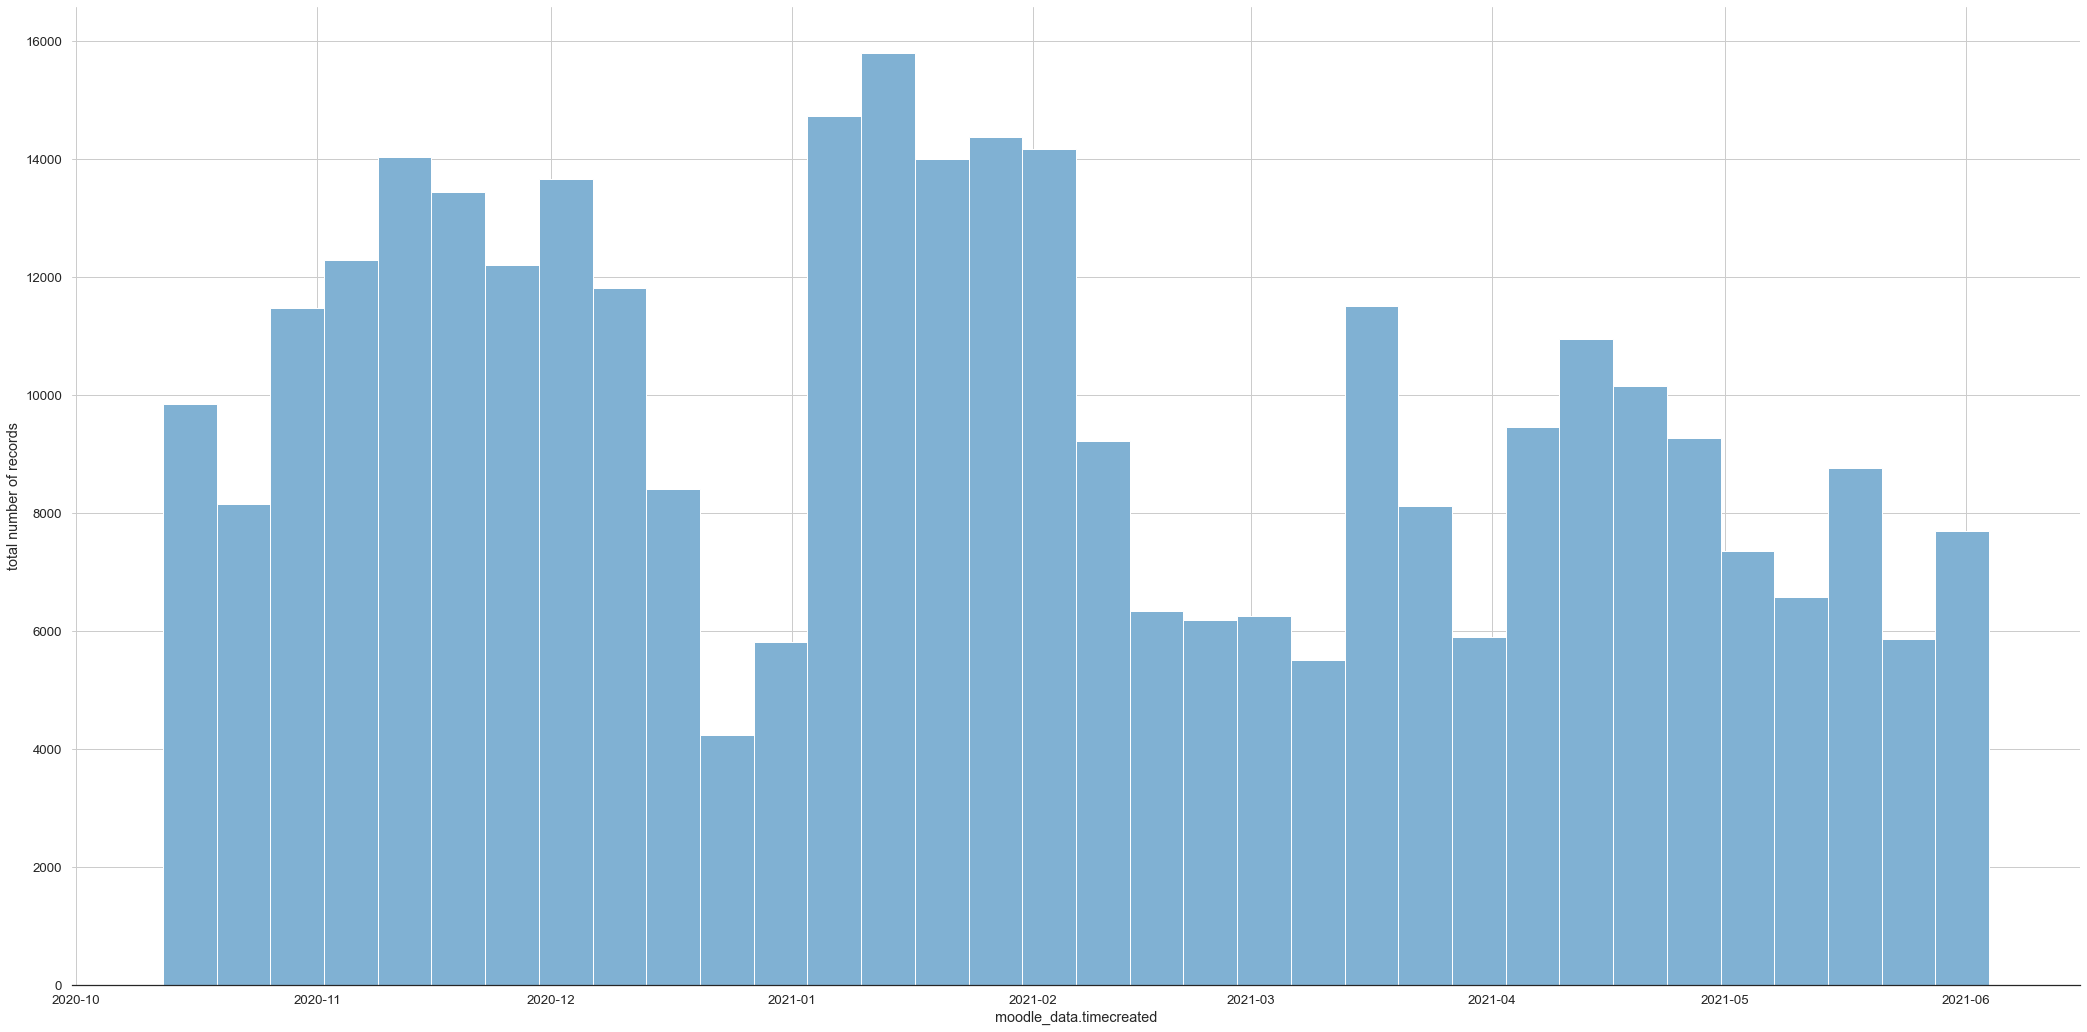

In [10722]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 18)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=moodle_data.timecreated, bins=8, color=colors_general[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(data=moodle_data.timecreated, bins=34, color=colors_general[4], alpha=1)

# Visualisierung der Menge der Log-Einträge über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(data=moodle_data.timecreated, bins=235, color=colors_general[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('moodle_data.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Menge_der_Log-Eintraege_pro_Tag.pdf', format='pdf')
plt.show()

**Anmerkung zur Betrachtung des obigen Wochen-Histogramms:** Auffällig sind die starken Anstiege und hohen Zahlen zu Beginn des Winter- und Sommersemesters, zu Beginn des neuen Jahres und zu Zeiten der Prüfungen (Prüfungszeitraum 1 und 2). Die Minima sind wie erwartet um die Weihnachtszeit, zwischen den Prüfungszeiträumen und vor Beginn des Sommersemesters deutlich sichtbar. Fraglich ist allerdings, warum im Mai die Zahlen abfallen und nicht ähnlich stark ansteigen, wie etwa im November. Es wäre zu erwarten, dass wie im Wintersemester auch im Sommersemester die Aktivitäten im zweiten Monat zunehmen sollten. Da es sich hierbei aber wohl um eine typische saisonale Schwäche handelt, die wohl auch in Präsenzstudiengängen anzutreffen ist, soll dieser Umstand nicht betrachtet werden. **Oder könnte man hieraus etwa eine Überlegung zur Kategorisierung des Verhaltens ableiten?**

&nbsp;
**Menge der Log-Einträge pro Benutzer und Woche über den Gesamtzeitraum**

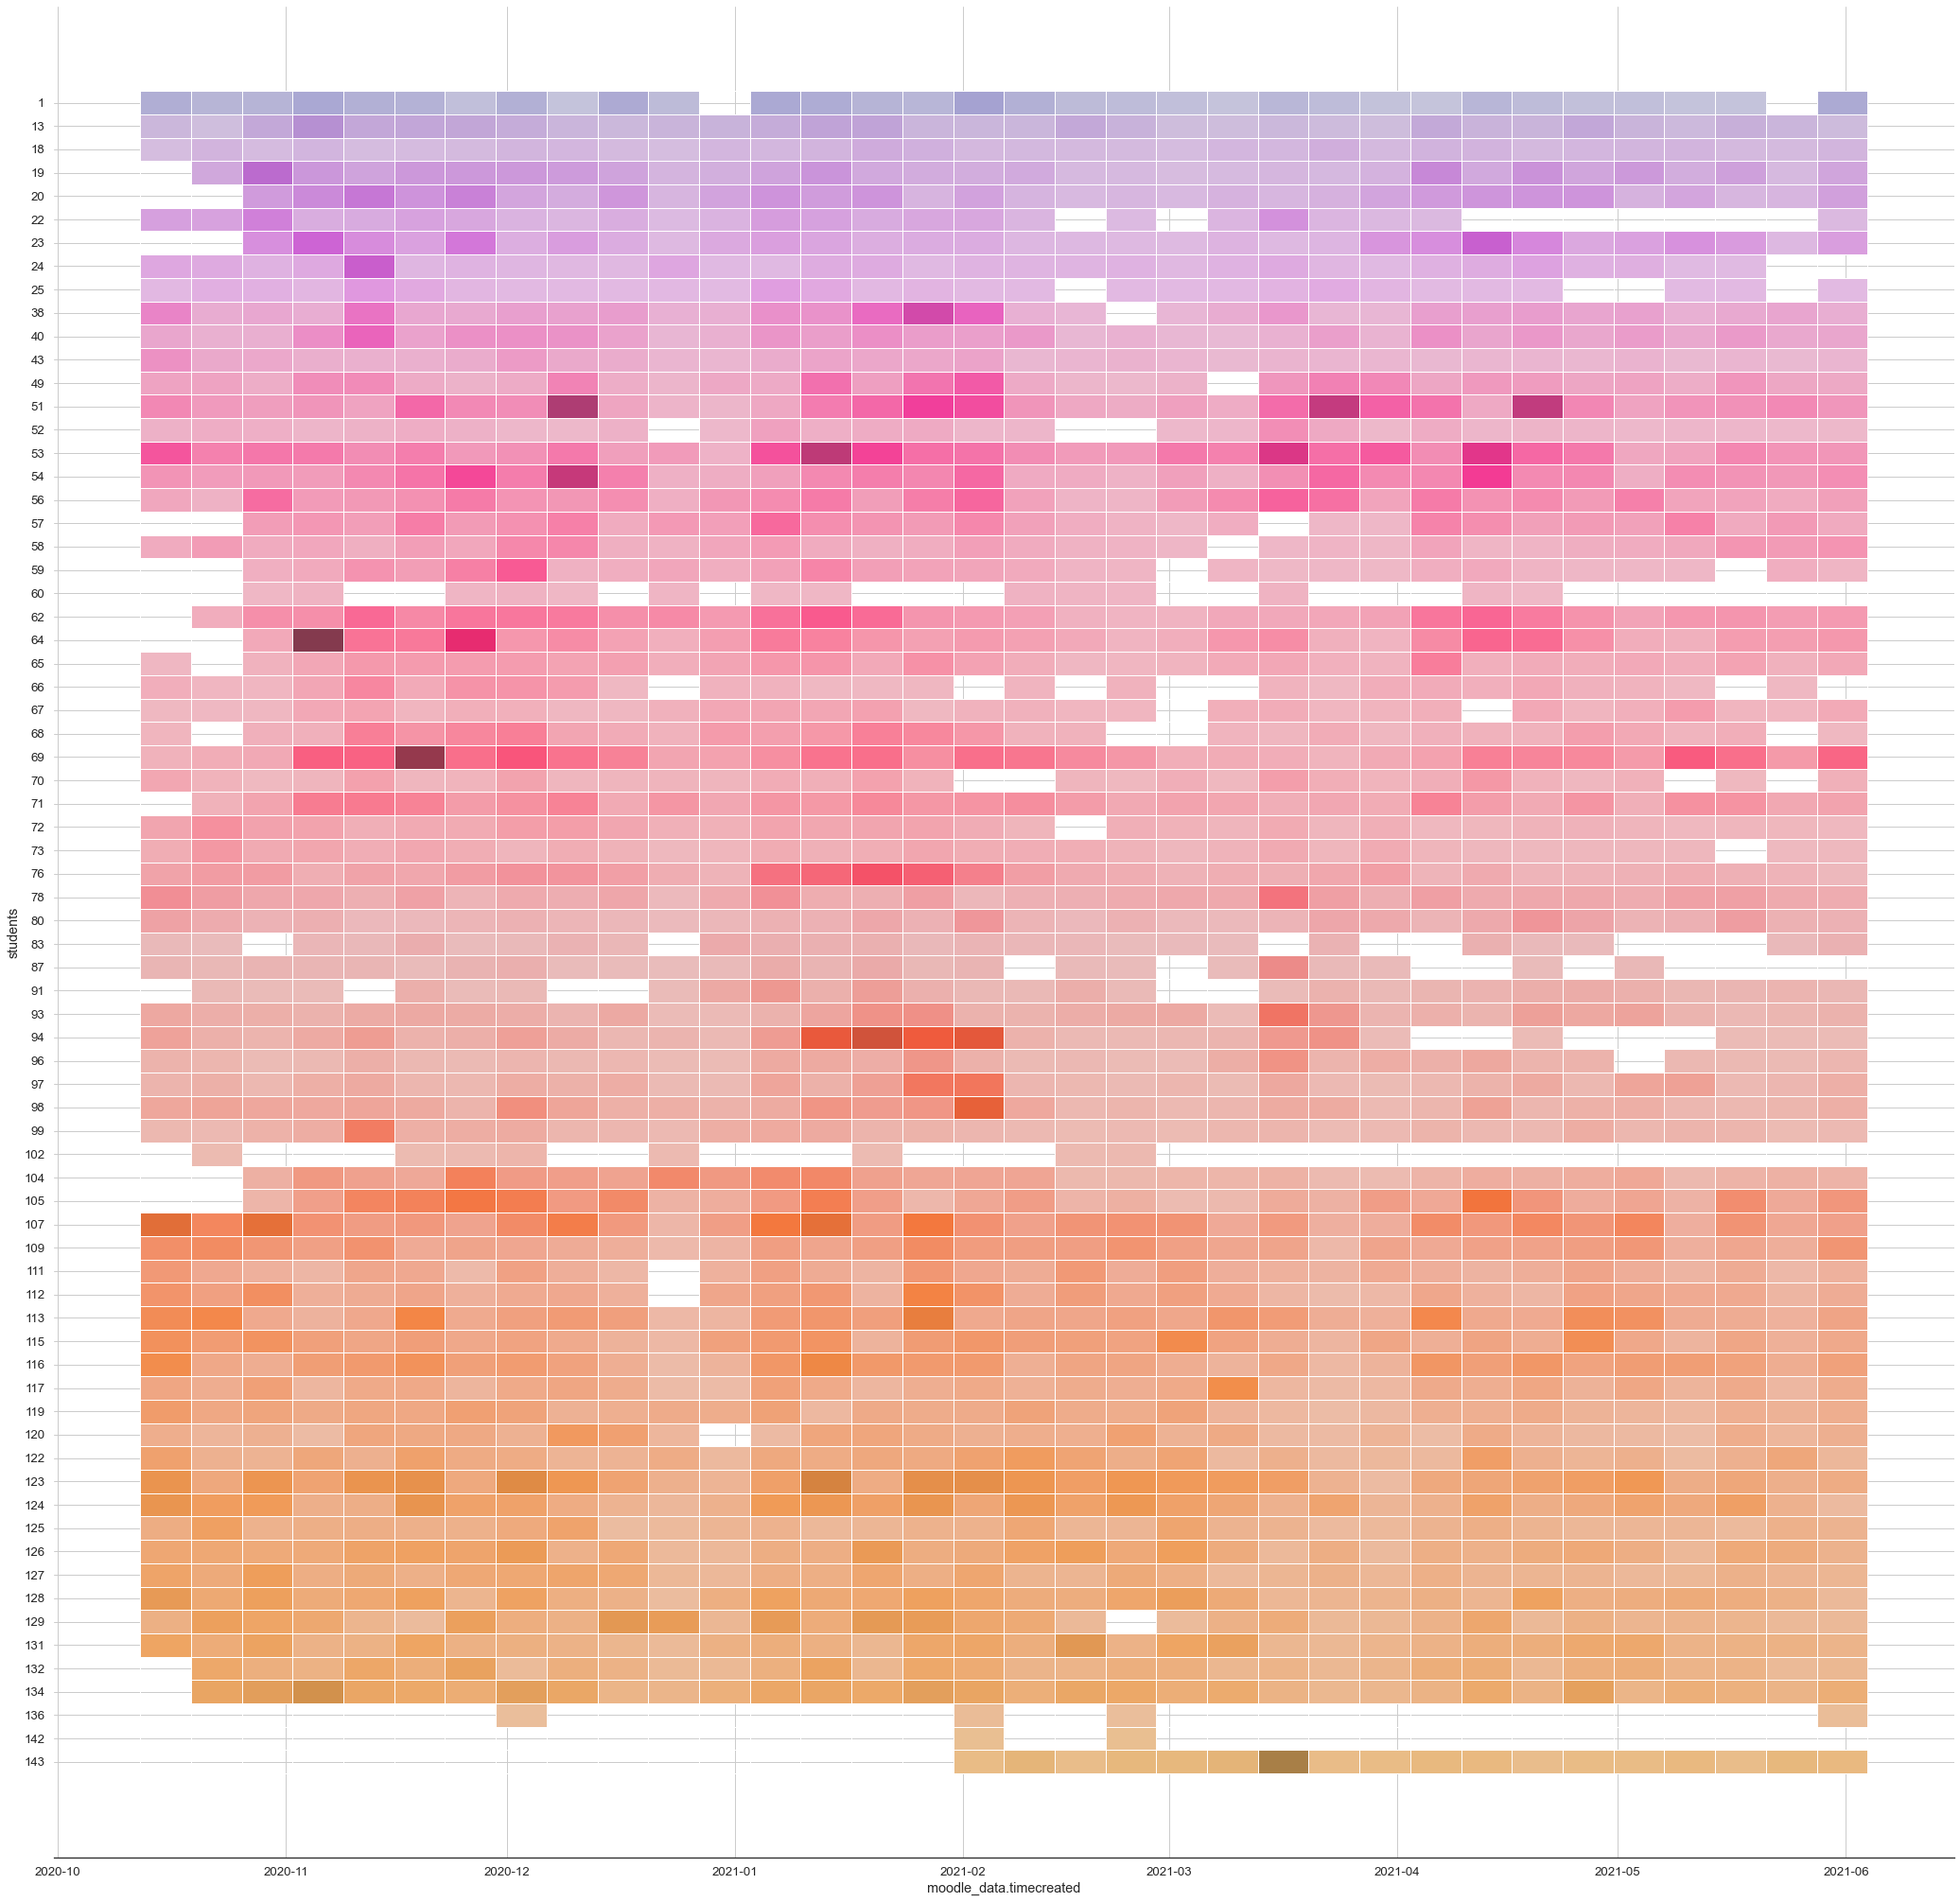

In [10723]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 36)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(x=moodle_data.timecreated, y=moodle_data.userid[moodle_data.userstatus == 'student'].astype(str), bins=34, hue=moodle_data.userid, hue_order=np.sort(moodle_data.userid.unique()), palette='rocket', edgecolor='white', legend=False)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('moodle_data.timecreated')
chart.set_ylabel('students')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung zur Betrachtung des obigen Wochen-Histogramms:** Die Wochen erhöhter und verminderter Benutzeraktivität, die im Diagramm durch eine stärkere bzw. schwächere Färbung angezeigt werden, korrespondieren wie erwartet mit den im vorhergehenden Histogram dargestellten Häufigkeiten von Log-Einträgen. Gleichzeitig werden hier bereits deutliche Unterschiede im Aktivitätsumfang der einzelnen Benutzer sichtbar.

&nbsp;
**Menge der Log-Einträge pro Woche und Studiengang über den Gesamtzeitraum**

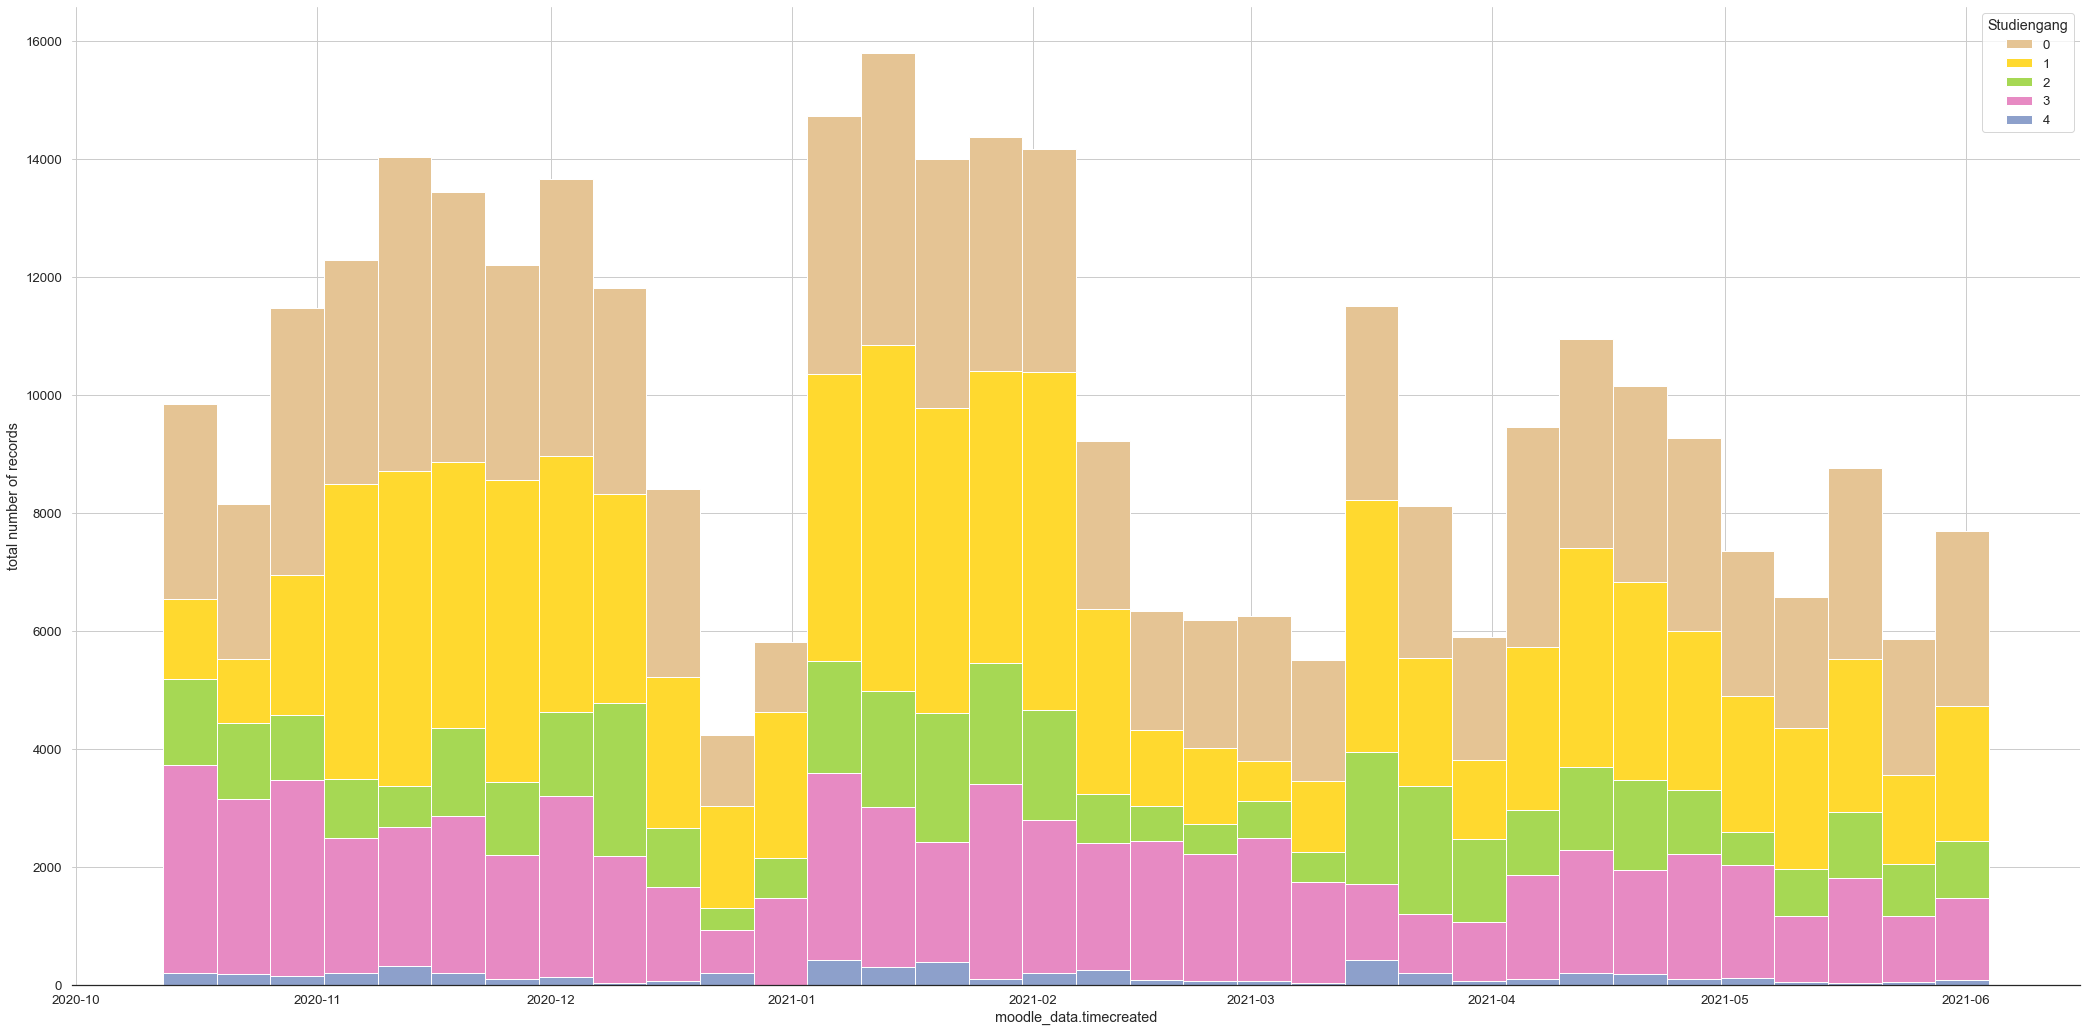

In [10724]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 18)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(data=moodle_data.timecreated, bins=8, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(x=moodle_data.timecreated, bins=34, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(data=moodle_data.timecreated, bins=235, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('moodle_data.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Menge_der_Log-Eintraege_pro_Tag.pdf', format='pdf')
plt.show()

**Anmerkung zur Betrachtung des obigen Wochen-Histogramms:** Es ist gut sichtbar, dass sich das Ausmaß der Aktivitäten in den einzelnen Studiengängen über die Wochen nicht gleichförmig verändert hat:
 - Anfang November ist bei Studiengang 1 ein starker Anstieg zu erkennen, während in den anderen Studiengängen die Aktivität gleichbleibt oder sogar abfällt.
 - Anfang Dezember ist bei Studiengang 2 ein starker Anstieg zu erkennen, während in den anderen Studiengängen die Aktivität abfällt.
 - Nach Prüfungszeitraum 1 ist bei Studiengang 1 und 2 deutlicher Rückgang zu erkennen, als bei Studiengang 3. Studiengang 4 kann hier sogar zulegen.
 - Zwischen den Prüfungszeiträumen hält Studiengang 3 die Aktivität vergleichsweise hoch
 - Zu Beginn des Prüfungszeitraums 2 ist bei Studiengang 1, 2 und 3 ein deutlicher Anstieg zu erkennen, während bei Studiengang 3 die Aktivität nachlässt.
 - Im restlichen Zeitraum verändern sich die Aktivitäten relativ gleichförmig.
 - Bemerkenswert ist auch, dass sich die Aktivität im Studiengang 0 außer zu Mitte Dezember und direkt nach dem Prüfungszeitraum 1 über die ganze Zeit hinweg relativ gleichförmig zur Summe der anderen Studiengänge verändert hat.

&nbsp;
**Menge der Log-Einträge pro Woche über den Gesamtzeitraum mit und ohne Personenbezug**

In [10725]:
relatedusers_per_week = pd.DataFrame()
relatedusers_per_week['other'] = moodle_data.timecreated[moodle_data.relateduserstatus == 'other'].groupby(moodle_data.year_week).count()
relatedusers_per_week['student'] = moodle_data.timecreated[(moodle_data.relateduserstatus == 'student') & (moodle_data.userid != moodle_data.relateduserid)].groupby(moodle_data.year_week).count()
relatedusers_per_week['none'] = moodle_data.timecreated[moodle_data.relateduserstatus == 'none'].groupby(moodle_data.year_week).count()
display(relatedusers_per_week)

,other,student,none
year_week,,,
2020-41,358,1130,5343
2020-42,370,874,5513
2020-43,830,1955,6377
2020-44,639,1485,8390
2020-45,1197,1614,9545
2020-46,606,1905,8184
2020-47,218,1277,7649
2020-48,713,2207,8430
2020-49,317,932,7981


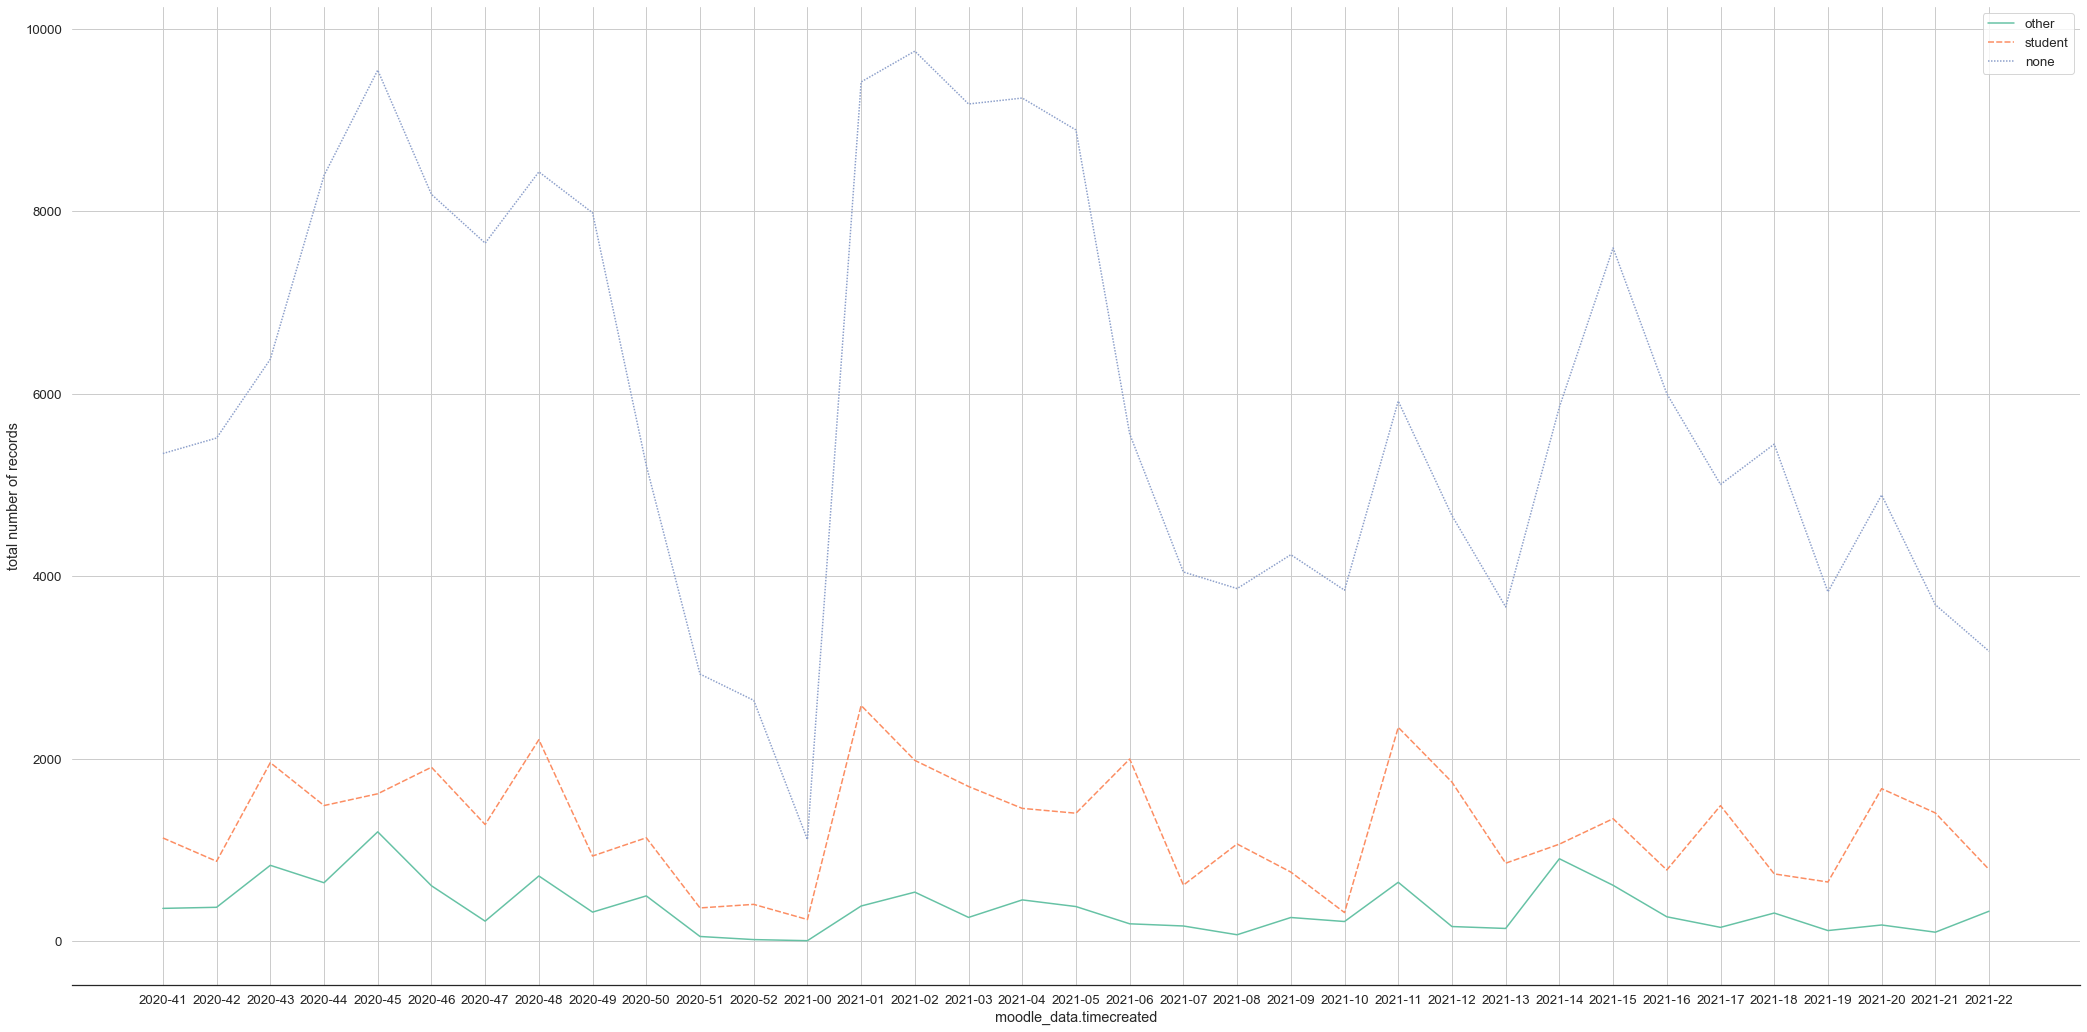

In [10726]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 18)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge mit und ohne Personenbezug über 34 Wochen (Gesamtzeitraum)
chart = sns.lineplot(data=relatedusers_per_week, palette='Set2', alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('moodle_data.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Menge_der_Log-Eintraege_pro_Tag.pdf', format='pdf')
plt.show()

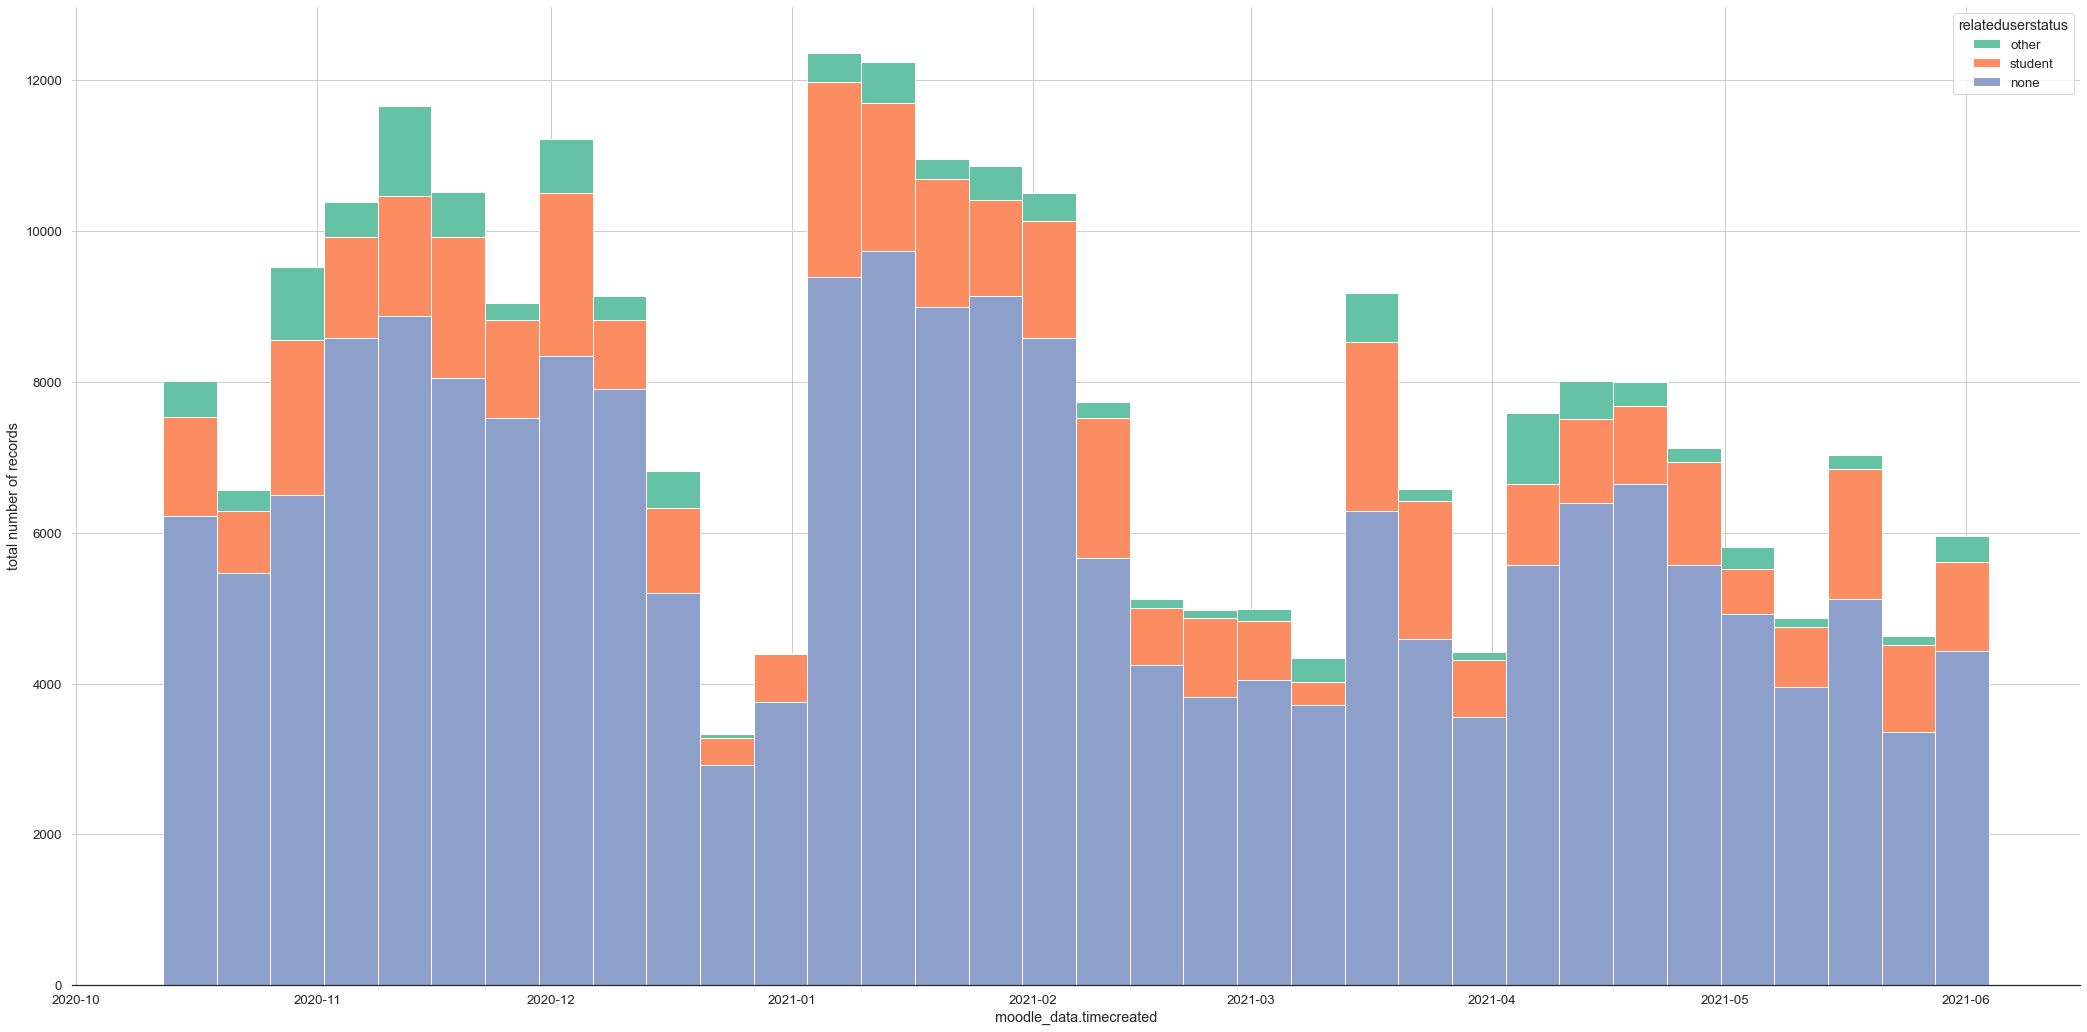

In [10727]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 18)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 8 Monate (Gesamtzeitraum)
# chart = sns.histplot(x=moodle_data.timecreated[moodle_data.userid != moodle_data.relateduserid], bins=8, hue=moodle_data.relateduserstatus, multiple="stack", palette='Set2', alpha=1)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 34 Wochen (Gesamtzeitraum)
chart = sns.histplot(x=moodle_data.timecreated[moodle_data.userid != moodle_data.relateduserid], bins=34, hue=moodle_data.relateduserstatus, multiple="stack", palette='Set2', alpha=1)

# Visualisierung der Menge der Log-Einträge pro Studiengang über 235 Tage (Gesamtzeitraum)
# chart = sns.histplot(x=moodle_data.timecreated[moodle_data.userid != moodle_data.relateduserid], bins=235, hue=moodle_data.relateduserstatus, multiple="stack", palette='Set2', alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('moodle_data.timecreated')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/Menge_der_Log-Eintraege_pro_Tag.pdf', format='pdf')
plt.show()

**Anmerkung zur Betrachtung des obigen Linien- und Wochen-Histogramms:** Im wesentlichen zeigen beide Darstellungen bis auf geringe Abweichungen ein sehr ähnliches Bild. Bis auf wenige Ausnahmen korrelieren Zu- und Abnahmen von Log-Einträgen mit Personenbezug generell mit solchen ohne Personenbezug.
 - Mitte Dezember ist bei den Log-Einträgen ohne Personenbezug ein starker Rückgang zu erkennen, während solche mit Personenbezug stärker ausfallen.
 - In den Zeiten vor den Prüfungen nahmen die Log-Einträge mit Personenbezug überraschenderweise ab. Es ist noch zu prüfen, ob dies einen Rückgang an Kommunikation bedeutet.

&nbsp;
**Menge der Log-Einträge für einen Studenten pro Woche über den Gesamtzeitraum (optional)**

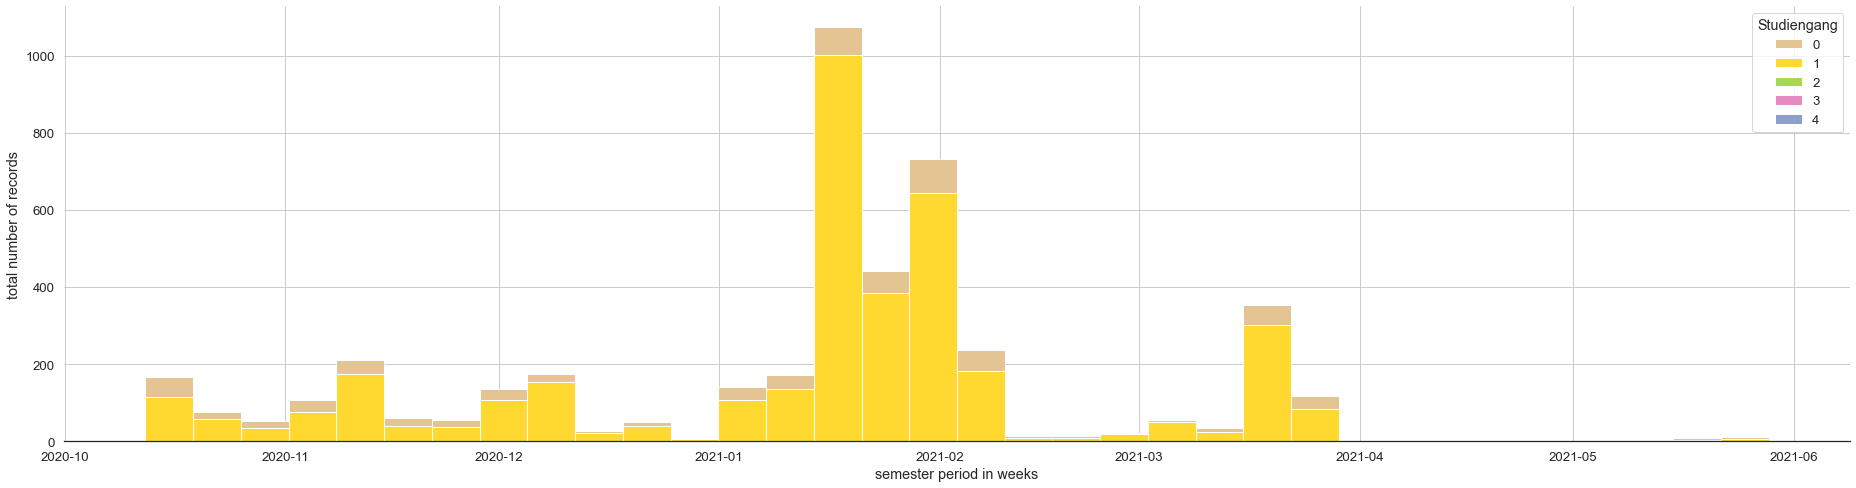

In [10762]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Woche und Studiengang über den Gesamtzeitraum
chart = sns.histplot(x=moodle_data.timecreated[moodle_data.userid == 94], bins=34, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='both')
chart.set_axisbelow(True)
chart.set_xlabel('semester period in weeks')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

### Verteilung der Log-Einträge über Semesterabschnitte

Es wäre noch zu klären, wie die Semesterabschnitte sinnvoll bestimmt werden sollten. Ein Vorschlag wäre eine Einteilung in:
- Vorlesungszeit, Prüfungszeitraum 1, Zwischenphase, Prüfungszeitraum 2, Endphase/Vorlesungszeit neues Semester

oder optional

- die beiden Prüfungszeitraume um die beiden letzten zwei bis vier Wochen vor den Prüfungen zu ergänzen und so vielleicht das gesamte Prüfungsgeschehen besser darstellen zu können.

Das gesamte Geschehen in diesen Phasen könnte zusätzlich auch differenziert nach Studiengängen oder nach unterschiedlichem Lern- und Kommunikationsverhalten dargestellt werden. Es wäre auch noch einmal zu besprechen, woran sich unterschiedliches ern- und Kommunikationsverhalten festmacht. Eine Unterscheidung nur über den relateduserstatus ist vielleicht nicht ausreichend und müsste durch eine Betrachtung von Actions ergänzt werden.

&nbsp;
**Anteilige Mengen von Log-Einträgen pro Student und Semesterabschnitt**

In [10729]:
# Ermittlung der absoluten Mengen an Log-Einträgen pro Student und Tageszeit
loggings = pd.DataFrame()
loggings['total'] = moodle_data.daytime[moodle_data.userstatus == 'student'].groupby(moodle_data.userid).count()
loggings['before_exams'] = moodle_data.semesterperiod[(moodle_data.userstatus == 'student') & (moodle_data.semesterperiod == 'before_exams')].groupby(moodle_data.userid).count()
loggings['exams1'] = moodle_data.semesterperiod[(moodle_data.userstatus == 'student') & (moodle_data.semesterperiod == 'exams1')].groupby(moodle_data.userid).count()
loggings['between_exams'] = moodle_data.semesterperiod[(moodle_data.userstatus == 'student') & (moodle_data.semesterperiod == 'between_exams')].groupby(moodle_data.userid).count()
loggings['exams2'] = moodle_data.semesterperiod[(moodle_data.userstatus == 'student') & (moodle_data.semesterperiod == 'exams2')].groupby(moodle_data.userid).count()
loggings['after_exams'] = moodle_data.semesterperiod[(moodle_data.userstatus == 'student') & (moodle_data.semesterperiod == 'after_exams')].groupby(moodle_data.userid).count()
loggings.fillna(value=0, inplace=True)

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student und Tageszeit
# Aus Darstellungsgründen werden die anteiligen Mengen aufsummiert
loggings['before_exams'] = [i / j * 100 for i, j in zip(loggings['before_exams'], loggings['total'])] # aufsummiert
# loggings['after_exams'] = [i / j * 100 for i, j in zip(loggings['after_exams'], loggings['total'])] # nicht aufsummiert
loggings['exams1'] = [i / j * 100 + k for i, j, k in zip(loggings['exams1'], loggings['total'], loggings['before_exams'])] # aufsummiert
# loggings['exams2'] = [i / j * 100 for i, j in zip(loggings['exams2'], loggings['total'])] # nicht aufsummiert
loggings['between_exams'] = [i / j * 100 + k for i, j, k in zip(loggings['between_exams'], loggings['total'], loggings['exams1'])] # aufsummiert
# loggings['between_exams'] = [i / j * 100 for i, j in zip(loggings['between_exams'], loggings['total'])] # nicht aufsummiert
loggings['exams2'] = [i / j * 100 + k for i, j, k in zip(loggings['exams2'], loggings['total'], loggings['between_exams'])] # aufsummiert
# loggings['exams2'] = [i / j * 100 for i, j in zip(loggings['exams2'], loggings['total'])] # nicht aufsummiert

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student (hier jeweils 100%)
loggings['total'] = [i / j * 100 for i,j in zip(loggings['total'], loggings['total'])]

display(loggings)

,total,before_exams,exams1,between_exams,exams2,after_exams
userid,,,,,,
1,100.0,58.240621,69.754204,79.793014,84.760673,589.0
13,100.0,53.810624,61.570439,71.986143,74.965358,1084.0
18,100.0,39.130435,48.129424,58.543984,68.402427,625.0
19,100.0,55.881848,60.982312,65.224111,67.542504,1890.0
20,100.0,55.965476,61.922491,66.034862,68.894906,1838.0
...,...,...,...,...,...,...
132,100.0,47.157753,57.214934,69.593004,73.999327,773.0
134,100.0,50.658890,61.028300,75.372651,78.073018,1015.0
136,100.0,9.090909,51.515152,60.606061,60.606061,13.0


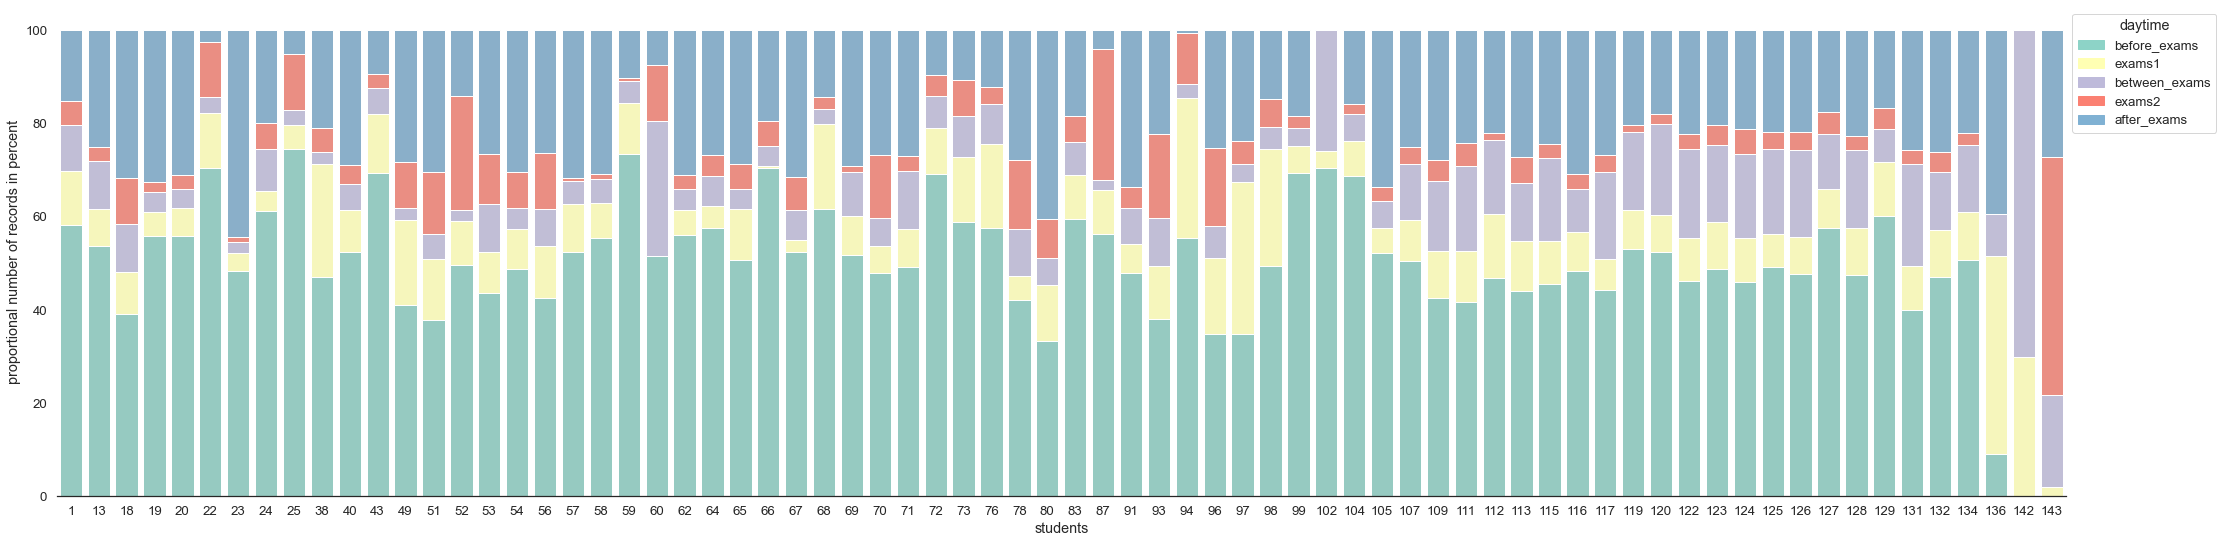

In [10730]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9))  # Größe der Visualisierung (in inch)

# Visualisierung der Gesamtmengen von Log-Einträgen pro Student und Tageszeit (in 100%)
bar_total = sns.barplot(x=loggings.index, y='total', data=loggings, color=colors_general[4], alpha=1)
# Visualisierung der anteiligen Mengen von Log-Einträgen pro Student und Tagestyp (in x%)
bar_exams2 = sns.barplot(x=loggings.index, y='exams2', data=loggings, color=colors_general[3], alpha=1)
bar_between_exams = sns.barplot(x=loggings.index, y='between_exams', data=loggings, color=colors_general[2], alpha=1)
bar_exams1 = sns.barplot(x=loggings.index, y='exams1', data=loggings, color=colors_general[1], alpha=1)
bar_before_exams = sns.barplot(x=loggings.index, y='before_exams', data=loggings, color=colors_general[0], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
bar1 = mpatches.Patch(color=colors_general[0], label='before_exams')
bar2 = mpatches.Patch(color=colors_general[1], label='exams1')
bar3 = mpatches.Patch(color=colors_general[2], label='between_exams')
bar4 = mpatches.Patch(color=colors_general[3], label='exams2')
bar5 = mpatches.Patch(color=colors_general[4], label='after_exams')
bar_total.set_xlabel('students')
bar_total.set_ylabel('proportional number of records in percent')
plt.legend(title='daytime', handles=[bar1, bar2, bar3, bar4, bar5], bbox_to_anchor=(1, 1))
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Diese Grafik zeigt gemeinsam mit der nachfolgenden die anteiligen Mengen der Zeiträume in denen ein Student aktiv war. Wichtig ist auch die Betrachtung der absoluten Zahlen, um eine Aussage über das wirkliche Ausmaß der Aktivität eines Studenten treffen zu können. Wie man mithilfe beider Grafiken sehen kann, gibt es vermutlich doch auch einige Studenten (z.B. 52, 87, 93, 94, 97, 98, 143) die ein hohes Maß an Aktivitäten in den Prüfungszeiträumen zu zeigen. Hier wären noch weitere Untersuchungen erforderlich, ggf. auch Einzelanalysen um diese als mit _sporadische_ Studenten zu bestätigen.

&nbsp;
**Absolute Mengen von Log-Einträgen pro Student und Semesterabschnitt**

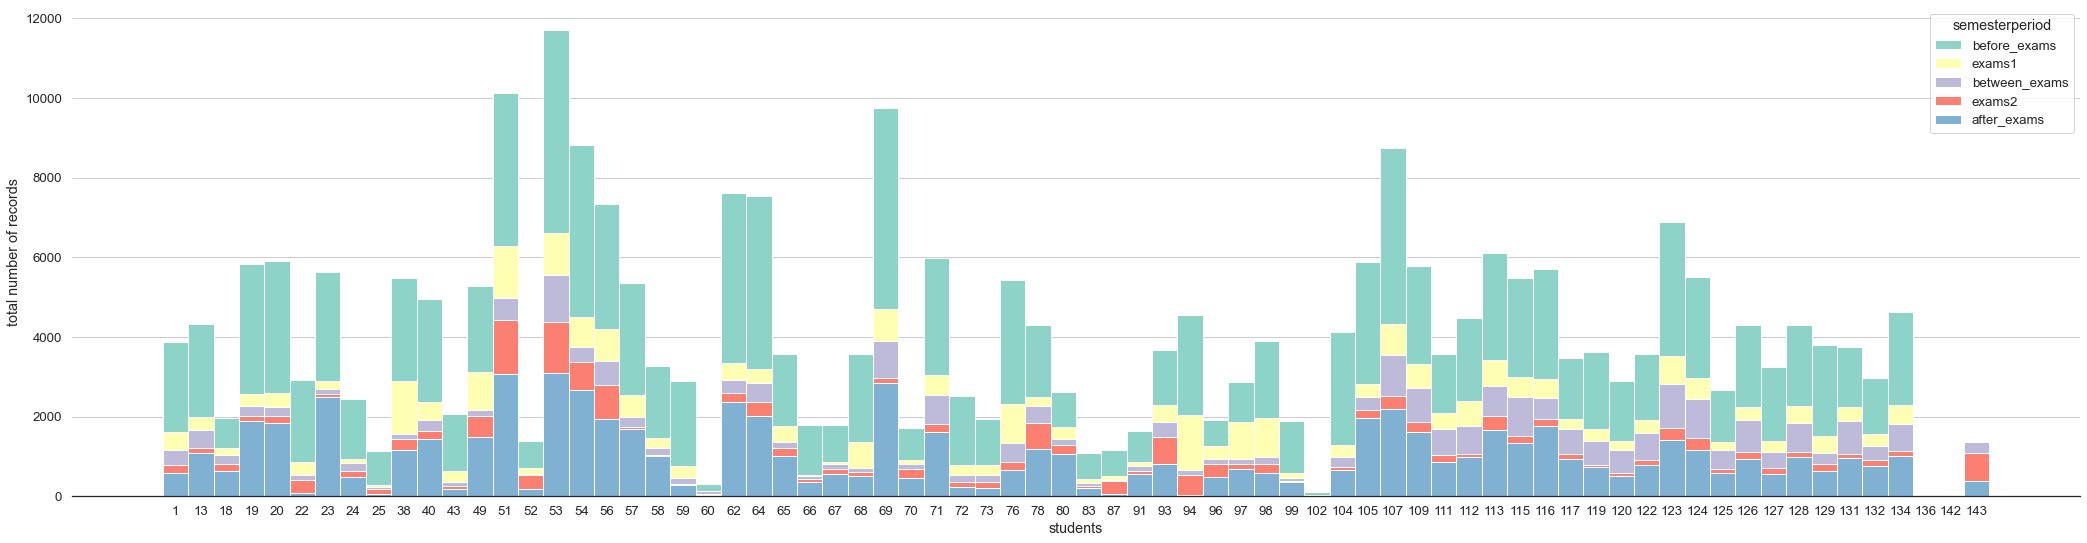

In [10731]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Mengen von Log-Einträgen pro Student und Semesterabschnitt
chart = sns.histplot(x=moodle_data.userid[moodle_data.userstatus == 'student'].astype(str), hue=moodle_data.semesterperiod, hue_order=['before_exams', 'exams1', 'between_exams', 'exams2', 'after_exams'], multiple="stack", palette=colors_general[0:5], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

### Verteilung der Log-Einträge pro Wochentag

&nbsp;
**Wochentag pro Log-Eintrag**

In [10732]:
# Ausgabe der Wochentage der protokollierten Log-Einträge
days_per_week = moodle_data.timecreated.dt.weekday.sort_values()
display(days_per_week)

0         0
85877     0
85876     0
85875     0
85874     0
         ..
36836     6
36835     6
36834     6
36842     6
259180    6
Name: timecreated, Length: 333773, dtype: int64

&nbsp;
**Menge der Log-Einträge pro Wochentag**

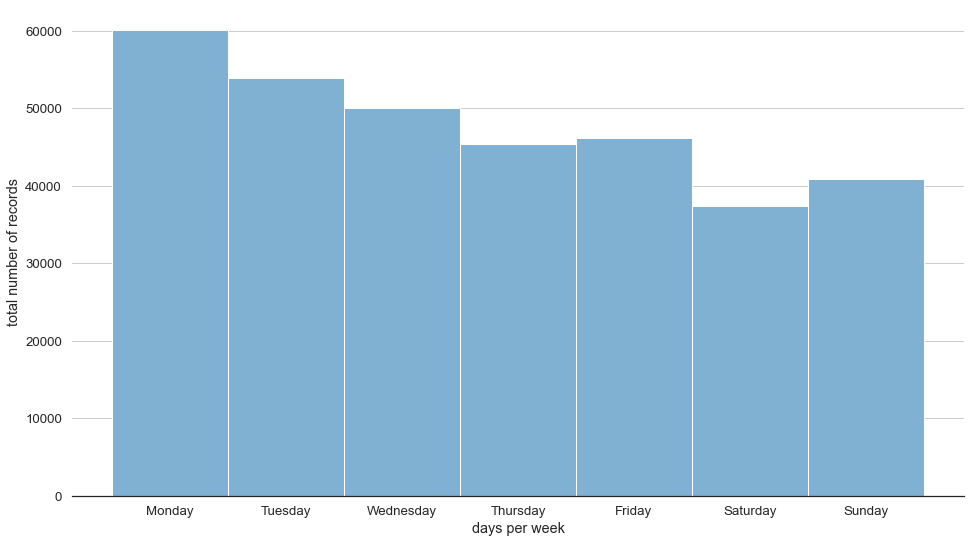

In [10733]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag
chart = sns.histplot(days_per_week, bins=7, discrete=True, color=colors_general[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Dass die Mengen an Log-Einträgen gerade an den Wochenendtagen am geringsten sind, entspricht nicht der Vermutung, dass Online-Studenten verstärkt am Wochenende aktiv sind und überrascht daher.

&nbsp;
**Menge der Log-Einträge pro Wochentag und Studiengang**

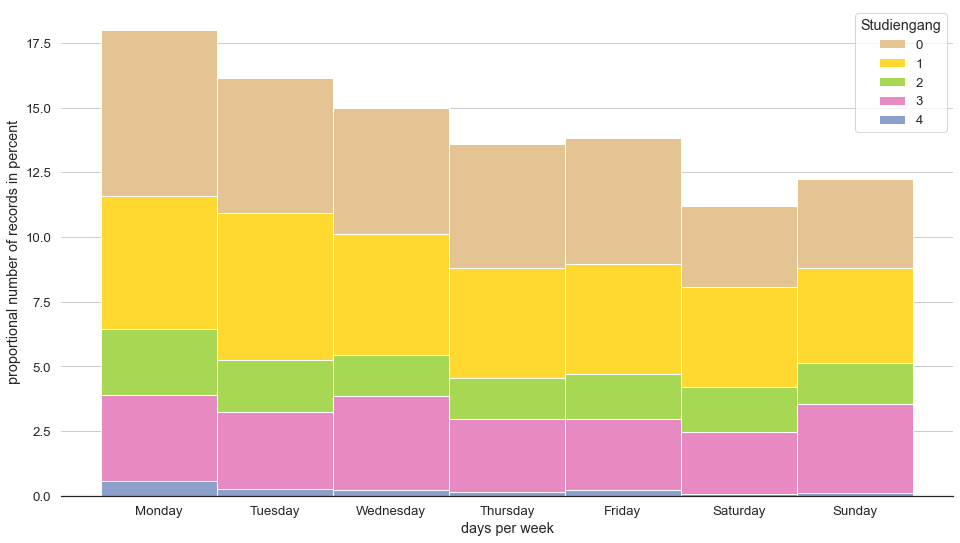

In [10734]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Studiengang
chart = sns.histplot(x=moodle_data.timecreated.dt.weekday, bins=7, discrete=True, stat="percent", hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('days per week')
chart.set_ylabel('proportional number of records in percent')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

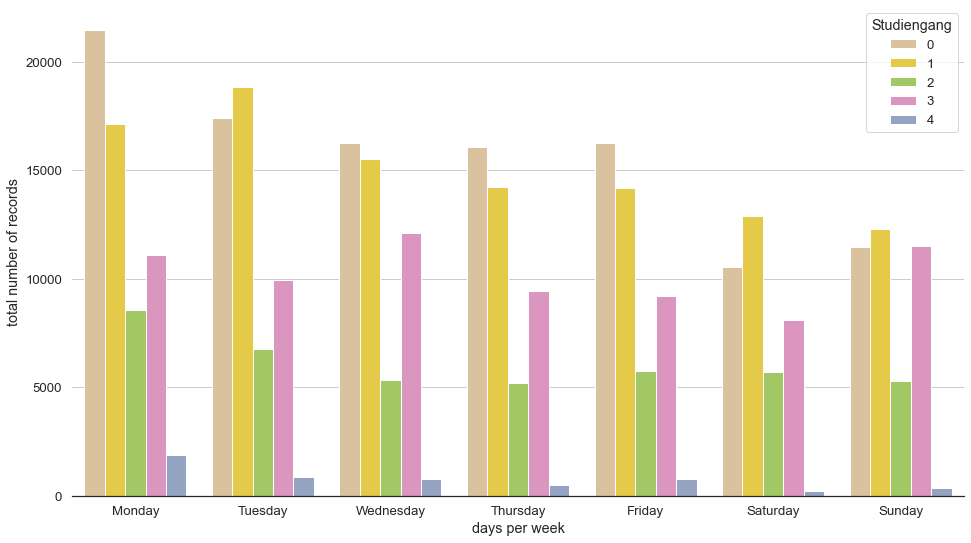

In [10735]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Studiengang
chart = sns.countplot(x=days_per_week, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.legend(title='studies', loc='upper right', labels=['0', '1', '2', '3', '4'])
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Der Rückgang der unter der Woche vergleichsweise hohen Mengen an Log-Einträgen im Studiengang 0 fällt deutlich stärker aus, als der Rückgang der Aktivitäten in den Fachkursen. Dies könnte auf ein unterschiedliches Kommunikationsverhalten an Arbeitstagen und an Wochenenden hindeuten. In jedem Fall beeinflusst der Rückgang im Studiengang 0 das Gesamtergebnis deutlich. Studenten im Studiengang 3 sind an Sonntagen relativ betrachtet wesentlich aktiver als andere.

&nbsp;
**Menge der Log-Einträge über alle Wochentage**

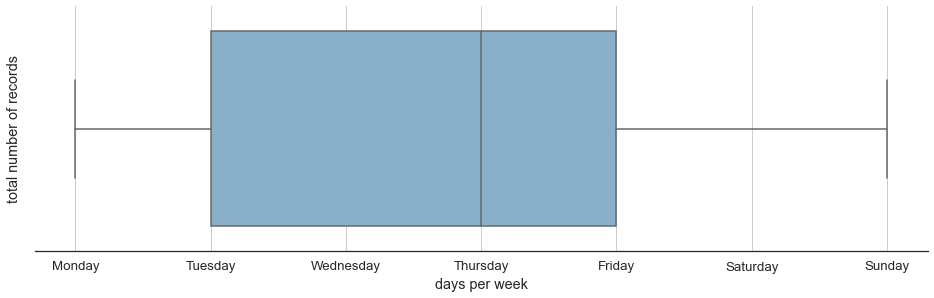

In [10736]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 4.5))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über alle Wochentage
chart = sns.boxplot(x=days_per_week, orient='h', color=colors_general[4])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Die studentischen Aktivitäten orientierten sich weitgehend an einer normalen Arbeitswoche, die Hälfte aller Interaktionen wurde im Zeitraum von Dienstag bis Freitag verzeichnet.

&nbsp;
**Menge der Log-Einträge pro Studiengang über alle Wochentage**

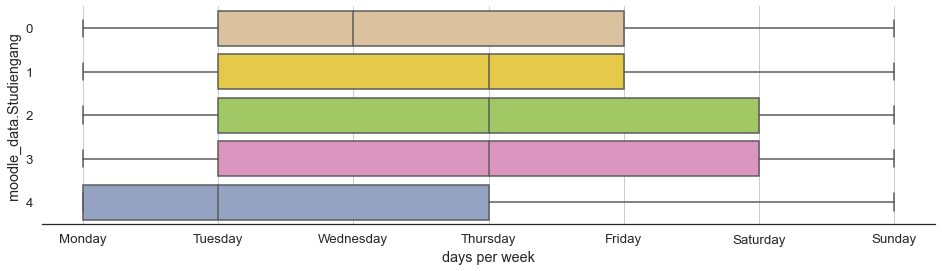

In [10737]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über alle Wochentage und Studiengang
chart = sns.boxplot(x=days_per_week, y=moodle_data.Studiengang, order=['0', '1', '2', '3', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('moodle_data.Studiengang')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Montags wurden vergleichsweise viele Aktivitäten festgestellt. Insbesondere die Studenten im Studiengang 4 haben an Montagen mehr gearbeitet, und im Verlaufe des Dienstags bereits die Hälfte ihrer Arbeit erledigt (allerdings ist die Gesamtzahl mit 5 Studenten im Vergleich zu den anderen Studiengängen gering und daher nur bedingt repräsentativ). An den Wochenenden wurde überraschenderweise nur wenig gearbeitet. Hier waren dann die Studenten im Studiengang 3 wieder etwas aktiver als andere in den anderen Studiengängen.

&nbsp;
**Menge der Arbeitstage pro Student**

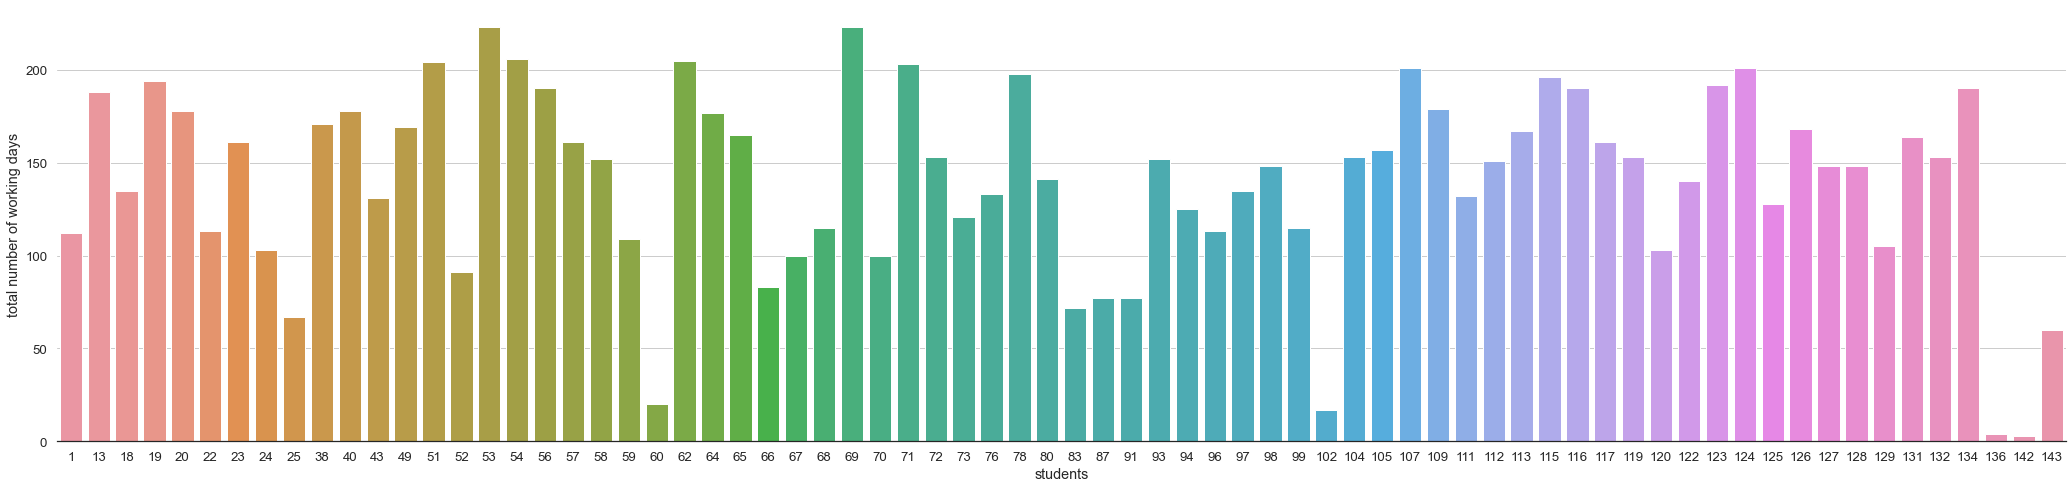

In [10738]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 8))  # Größe der Visualisierung (in inch)

# Ermittlung der Menge der Arbeitstage pro Student
result = moodle_data.timecreated.dt.dayofyear.groupby(moodle_data.userid[moodle_data.userstatus == 'student']).nunique()
# Visualisierung der Menge der Arbeitstage pro Student
chart = sns.barplot(x=result.index.astype(int), y=result)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_xlabel('students')
chart.set_ylabel('total number of working days')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Der obige Countplot lässt erkennen, an wievielen Tagen im Gesamtzeitraum ein Student überhaupt aktiv war und gibt so z.B. sehr rasch Aufschluss über die Studenten, die nur wenig bis gar nicht gearbeitet haben.

Die nachfolgenden Visualisierungen sind nur optional zur Vorbereitung von Einzelbetrachtungen gedacht. Anhand der Boxplots kann man gezielt Studenten auswählen, die sich eventuell für eine Einzelanalyse eignen könnten.

&nbsp;
**Menge der Log-Einträge pro Wochentag und Student im Studiengang 0**

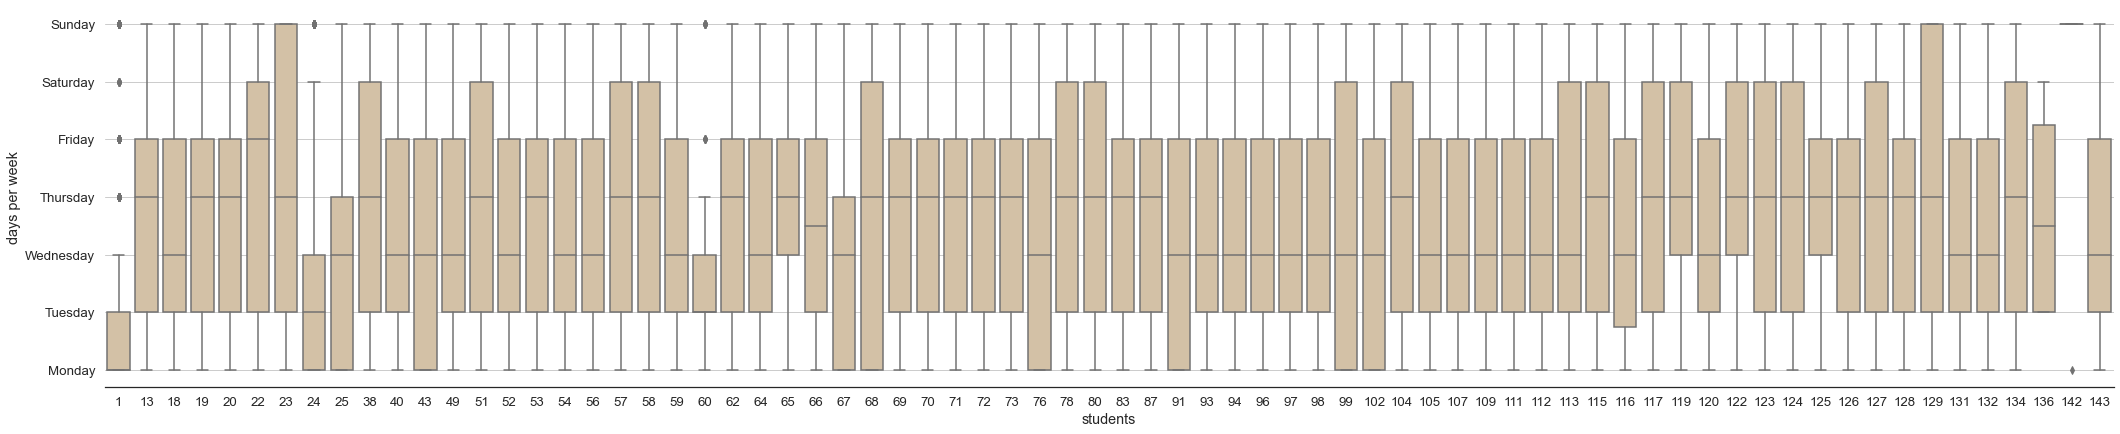

In [10739]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=((moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '0')].nunique() / 2), 7))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Student im Studiengang 0
chart = sns.boxplot(x=moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '0')], y=days_per_week, color=colors_studies[0])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge pro Wochentag und Student im Studiengang 1**

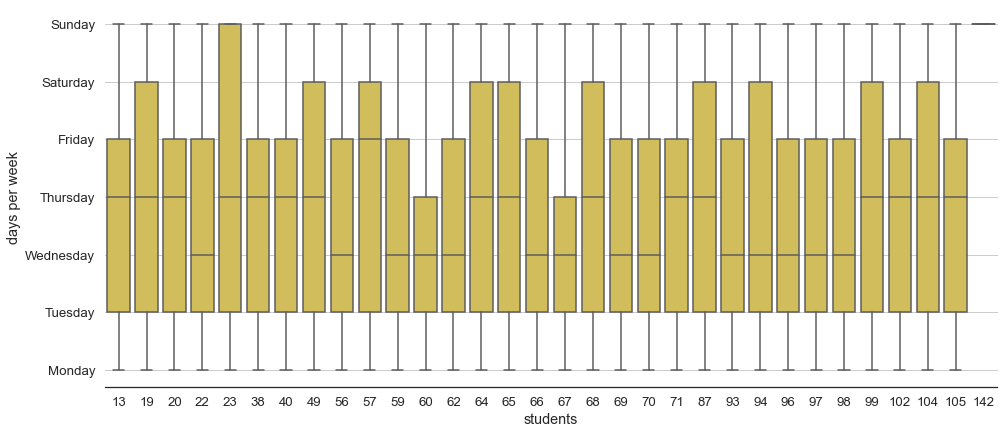

In [10740]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=((moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '1')].nunique() / 2), 7))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Student im Studiengang 1
chart = sns.boxplot(x=moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '1')], y=days_per_week, color=colors_studies[1])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge pro Wochentag und Student im Studiengang 2**

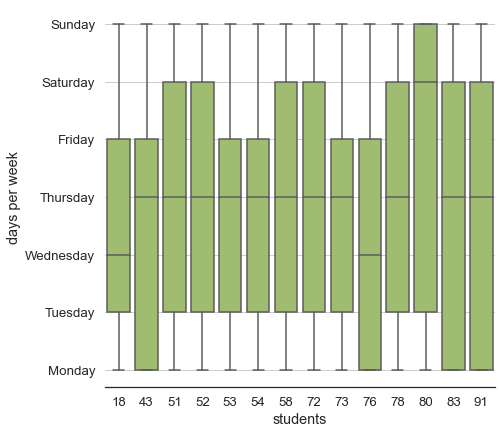

In [10741]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=((moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '2')].nunique() / 2), 7))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Student im Studiengang 2
chart = sns.boxplot(x=moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '2')], y=days_per_week, color=colors_studies[2])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge pro Wochentag und Student im Studiengang 3**

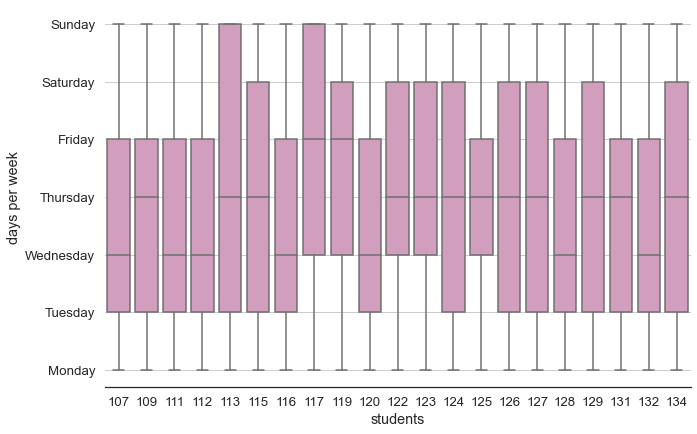

In [10742]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=((moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '3')].nunique() / 2), 7))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Student im Studiengang 3
chart = sns.boxplot(x=moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '3')], y=days_per_week, color=colors_studies[3])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge pro Wochentag und Student im Studiengang 4**

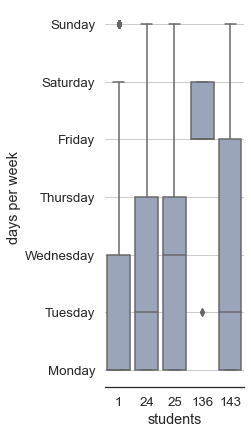

In [10743]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=((moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '4')].nunique() / 2), 7))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Student im Studiengang 4
chart = sns.boxplot(x=moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang == '4')], y=days_per_week, color=colors_studies[4])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge pro Wochentag und Student in verschiedenen Studiengängen**

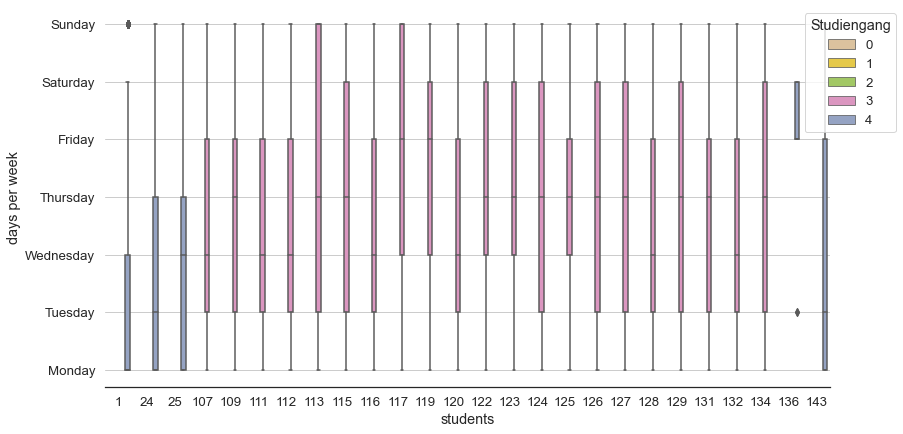

In [10744]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=((moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang > '2')].nunique() / 2), 7))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Student im Studiengang 3
chart = sns.boxplot(x=moodle_data.userid[(moodle_data.userstatus == 'student') & (moodle_data.Studiengang > '2')], y=days_per_week, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
plt.legend(title='Studiengang', bbox_to_anchor=[1.1, 1], loc='upper right')
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Anteilige Mengen von Log-Einträgen pro Student und Tagestyp**

In [10745]:
# Ermittlung der absoluten Mengen an Log-Einträgen pro Student
loggings = pd.DataFrame()
loggings['total'] = moodle_data.daytype[moodle_data.userstatus == 'student'].groupby(moodle_data.userid).count()

# Ermittlung der absoluten Mengen an Log-Einträgen pro Student und Tagestyp
loggings['workingday'] = moodle_data.daytype[(moodle_data.userstatus == 'student') & (moodle_data.daytype == 'workingday')].groupby(moodle_data.userid).count()
loggings['weekend'] = moodle_data.daytype[(moodle_data.userstatus == 'student') & (moodle_data.daytype == 'weekend')].groupby(moodle_data.userid).count()
loggings.fillna(value=0, inplace=True)

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student und Tagestyp
loggings['workingday'] = [i / j * 100 for i, j in zip(loggings['workingday'], loggings['total'])]
loggings['weekend'] = [i / j * 100 for i,j in zip(loggings['weekend'], loggings['total'])]

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student (hier jeweils 100%)
loggings['total'] = [i / j * 100 for i,j in zip(loggings['total'], loggings['total'])]

display(loggings)

,total,workingday,weekend
userid,,,
1,100.0,94.799483,5.200517
13,100.0,79.030023,20.969977
18,100.0,82.204247,17.795753
19,100.0,78.018204,21.981796
20,100.0,80.859706,19.140294
...,...,...,...
132,100.0,80.995627,19.004373
134,100.0,70.857637,29.142363
136,100.0,57.575758,42.424242


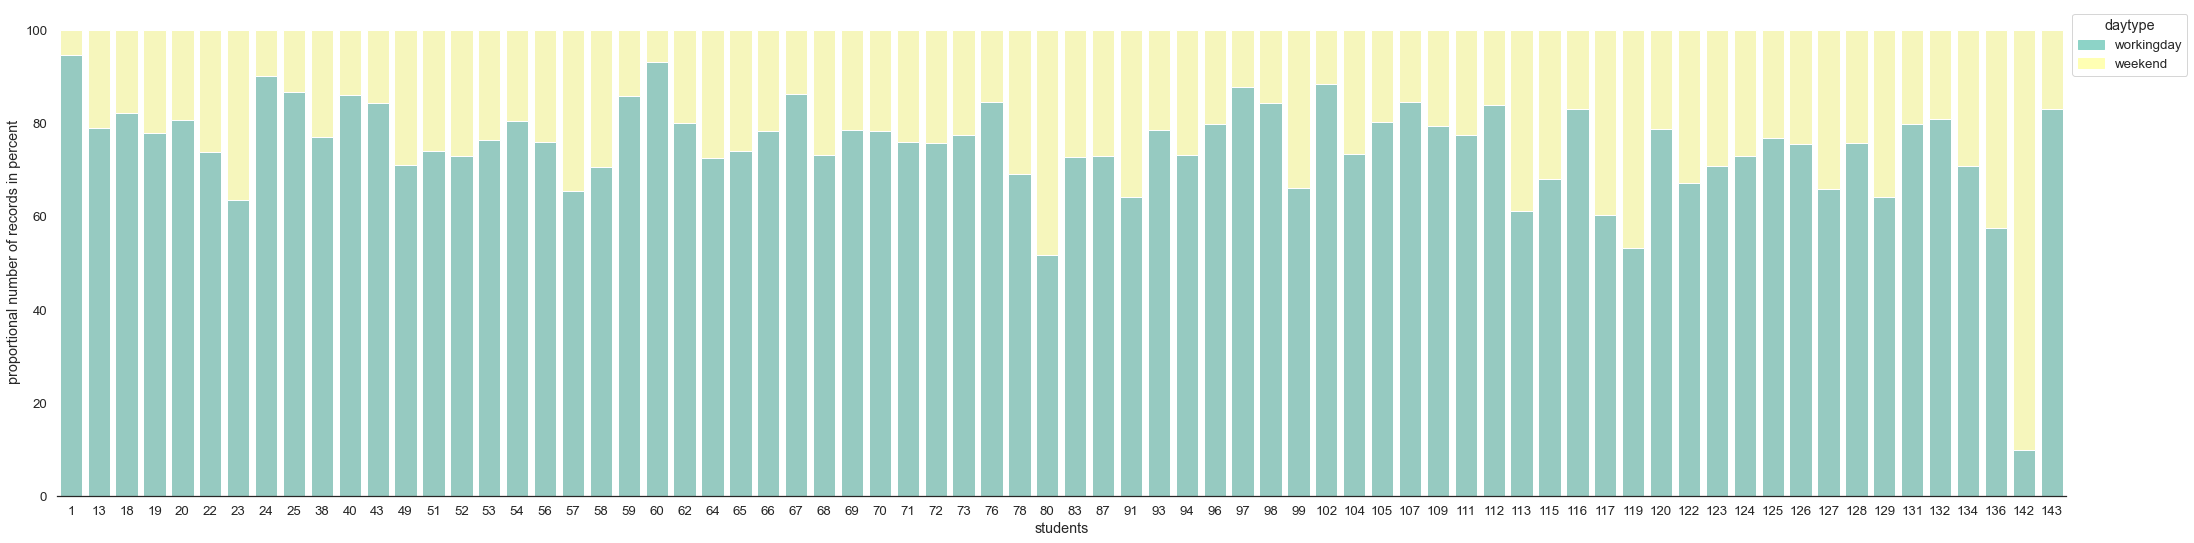

In [10746]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9))  # Größe der Visualisierung (in inch)

# Visualisierung der Gesamtmengen von Log-Einträgen pro Student und Tagestyp (in 100%)
bar_total = sns.barplot(x=loggings.index, y='total', data=loggings, color=colors_general[1], alpha=1)
# Visualisierung der anteiligen Mengen von Log-Einträgen pro Student und Tagestyp (in x%)
bar_workingday = sns.barplot(x=loggings.index, y="workingday", data=loggings, color=colors_general[0], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
bar1 = mpatches.Patch(color=colors_general[0], label='workingday')
bar2 = mpatches.Patch(color=colors_general[1], label='weekend')
bar_total.set_xlabel('students')
bar_total.set_ylabel('proportional number of records in percent')
plt.legend(title='daytype', handles=[bar1, bar2], bbox_to_anchor=(1, 1))
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Die obige Visualisierung veranschaulicht gut das Verhältnis der Aktivitäten über eine durchschnittliche Woche und widerlegt gut ersichtlich die Vermutung, dass Online-Studenten vermehrt am Wochenende arbeiten würden.

&nbsp;
**Absolute Mengen von Log-Einträgen pro Student und Tagestyp**

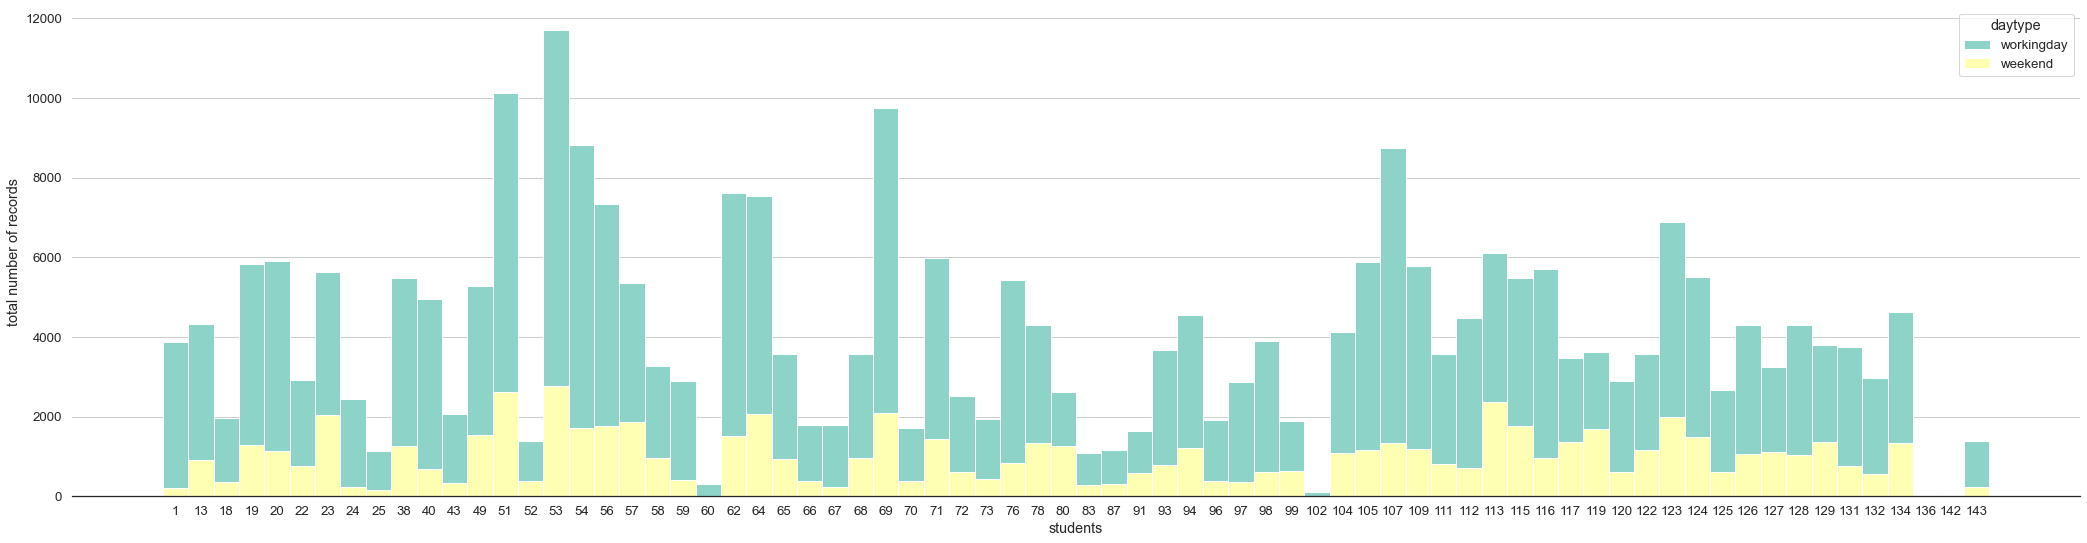

In [10747]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Mengen von Log-Einträgen pro Student und Tagestyp
chart = sns.histplot(x=moodle_data.userid[moodle_data.userstatus == 'student'].astype(str), hue=moodle_data.daytype, hue_order=['workingday', 'weekend'], multiple="stack", palette=colors_general[0:2], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Ergänzend zur Visualisierung darüber zeigt diese Grafik die tatsächlichen Zahlen und erkennt z.B. den Studenten 142 nicht als Wochendendarbeiter, sondern eher als Ausreißer der fast keine Aktivitäten gezeigt hatte (davon aber relativ viele am Wochenende). Bei Student 136 sieht es ganz ähnlich aus.

&nbsp;
**Menge der Log-Einträge pro Wochentag und Actions mit Personenbezug**

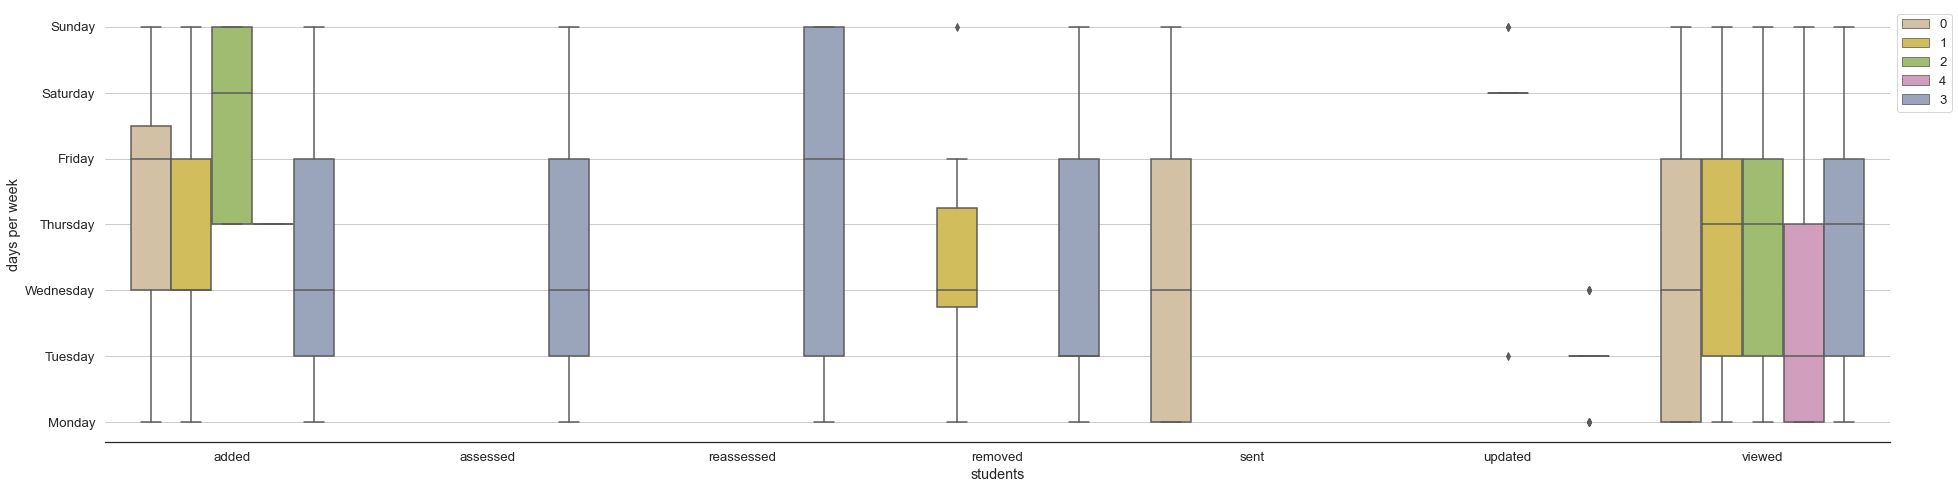

In [10748]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 8))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Actions ohne Personenbezug
chart = sns.boxplot(x=moodle_data.action[(moodle_data.userid != moodle_data.relateduserid) & (moodle_data.userstatus == 'student') & (moodle_data.relateduserstatus != 'none')].sort_values(), y=days_per_week, hue=moodle_data.Studiengang, palette=colors_studies)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Dieser Boxplot und auch der nachfolgende Countplot zeigen, dass sich zur genaueren Betrachtung der Kommunikation die sent- bzw. viewed-Actions eignen könnten. Hier wären z.B. bei aktivitätsbezogenen Analysen auch wieder Einzelbetrachtungen hilfreich. Das wäre noch zu diskutieren.

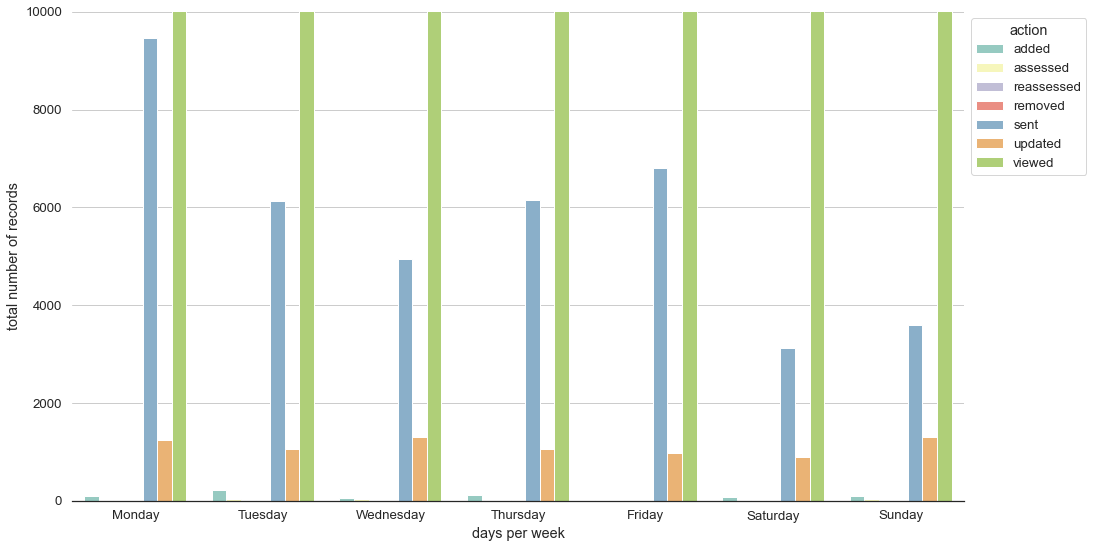

In [10749]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Studiengang
chart = sns.countplot(x=days_per_week, hue=moodle_data.action, hue_order=np.sort(moodle_data.action[(moodle_data.userid != moodle_data.relateduserid) & (moodle_data.userstatus == 'student') & (moodle_data.relateduserstatus != 'none')].unique()), palette=colors_general)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
plt.ylim(0, 10000)
sns.despine(left=True)
plt.legend(title='action', bbox_to_anchor=(1, 1))
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge pro Wochentag und Actions ohne Personenbezug**

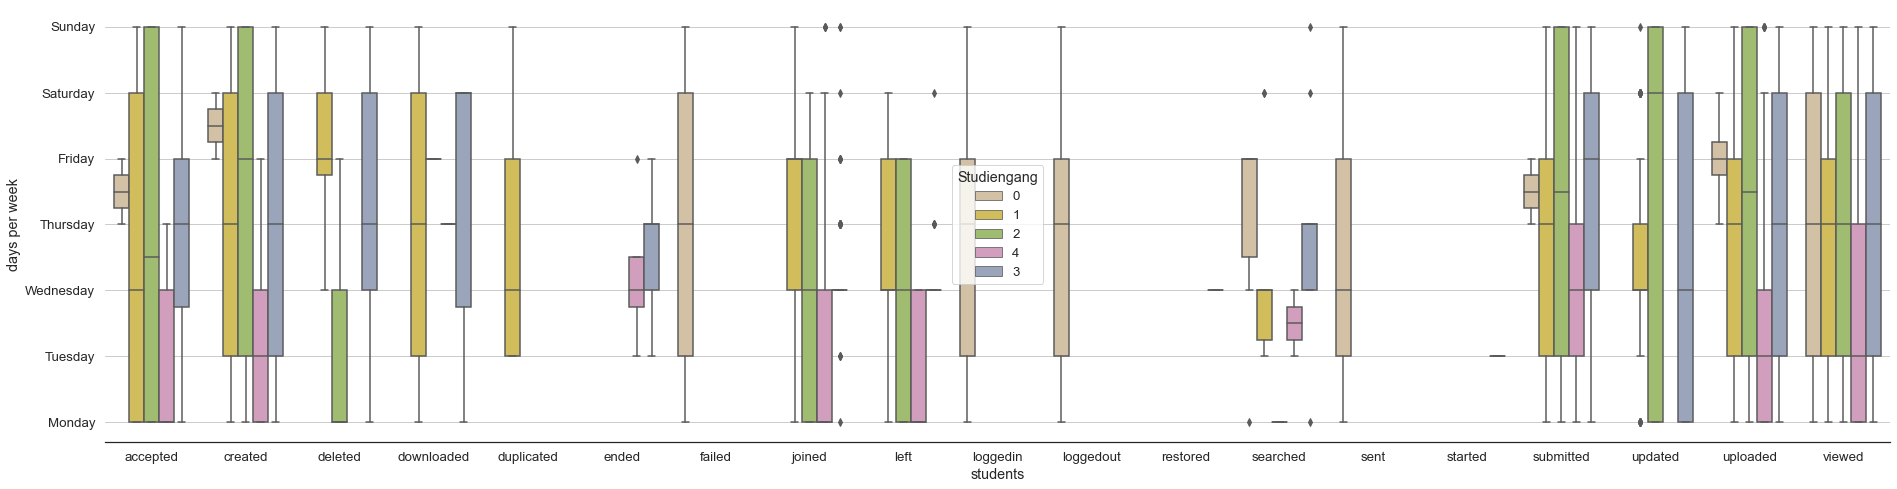

In [10750]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(32, 8))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Actions ohne Personenbezug
chart = sns.boxplot(x=moodle_data.action[(moodle_data.userstatus == 'student') & (moodle_data.relateduserstatus == 'none')].sort_values(), y=days_per_week, hue=moodle_data.Studiengang, palette=colors_studies)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.yaxis.set_ticks(range(0, 7, 1))
chart.set_yticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('students')
chart.set_ylabel('days per week')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

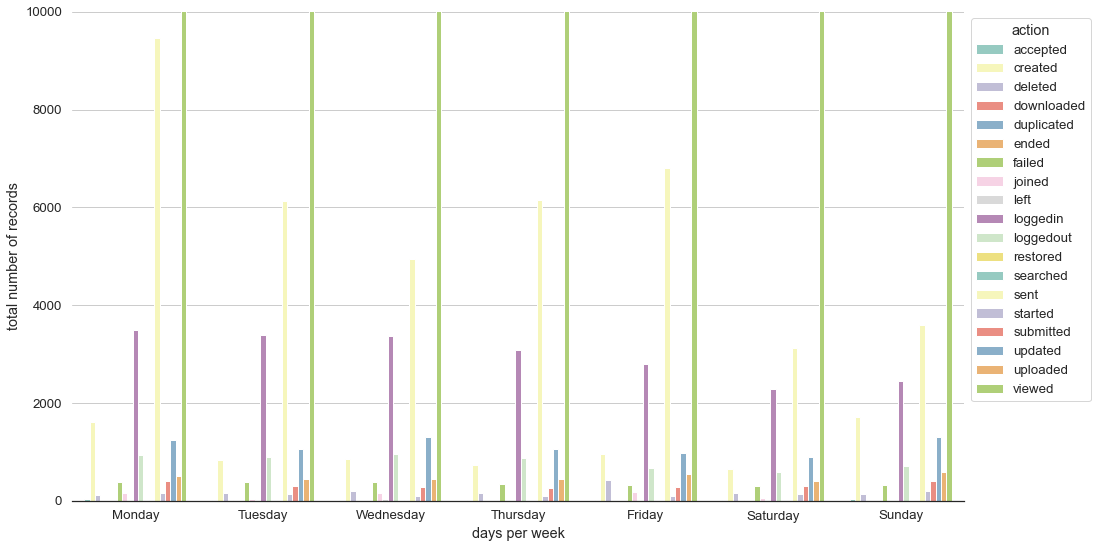

In [10751]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(16, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Wochentag und Studiengang
chart = sns.countplot(x=days_per_week, hue=moodle_data.action, hue_order=np.sort(moodle_data.action[(moodle_data.userid != moodle_data.relateduserid) & (moodle_data.userstatus == 'student') & (moodle_data.relateduserstatus == 'none')].unique()), palette=colors_general)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 7, 1))
chart.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
chart.set_xlabel('days per week')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
plt.ylim(0, 10000)
sns.despine(left=True)
plt.legend(title='action', bbox_to_anchor=(1, 1))
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

### Verteilung der Log-Einträge pro Tagesstunde

&nbsp;
**Tagesstunde pro Log-Eintrag**

In [10752]:
# Ausgabe der Tagesstunden der protokollierten Log-Einträge
hours_per_day = moodle_data.timecreated.dt.hour.sort_values()
display(hours_per_day)

112723     0
200807     0
200808     0
200809     0
200810     0
          ..
232972    23
232971    23
232970    23
232978    23
244347    23
Name: timecreated, Length: 333773, dtype: int64

&nbsp;
**Menge der Log-Einträge pro Tagesstunde**

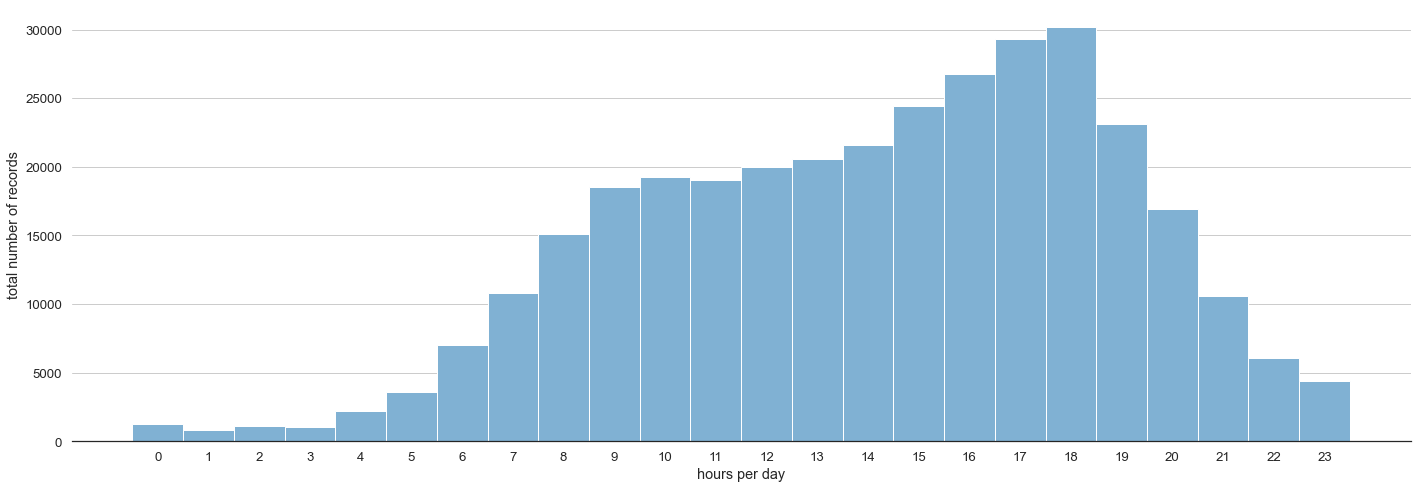

In [10753]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde
chart = sns.histplot(hours_per_day, bins=24, discrete=True, color=colors_general[4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Dass die Mengen an Log-Einträgen gerade in den Abendstunden am geringsten sind, entspricht nicht der Vermutung, dass Online-Studenten verstärkt am Abend aktiv sind und überrascht daher.

&nbsp;
**Menge der Log-Einträge pro Tagesstunde und Studiengang**

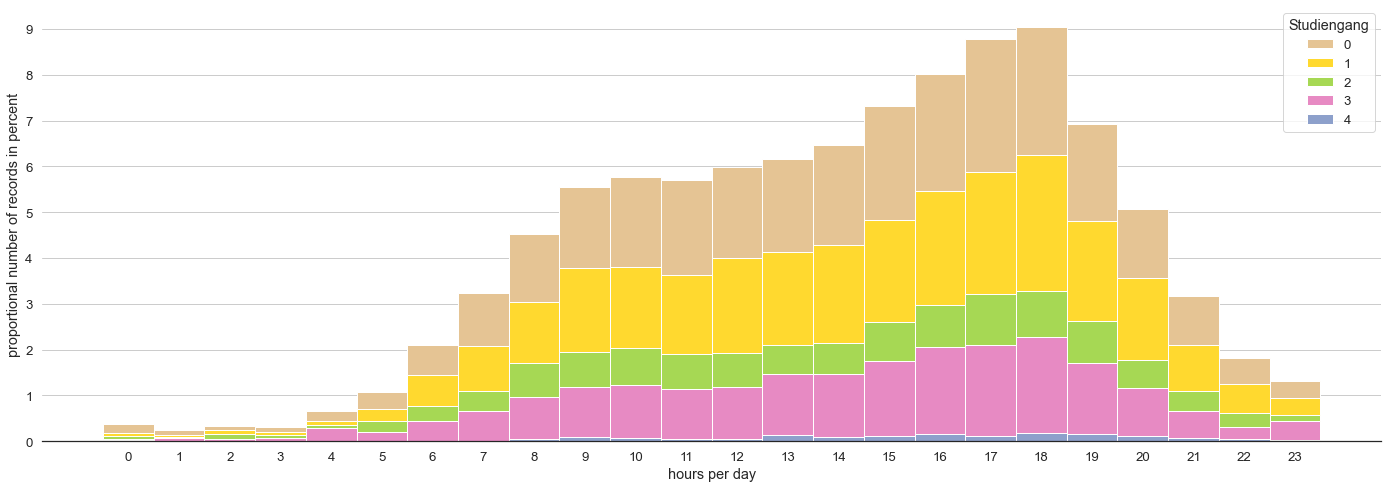

In [10754]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde und Studiengang
chart = sns.histplot(x=moodle_data.timecreated.dt.hour, bins=24, discrete=True, stat="percent", hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'], multiple="stack", alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('hours per day')
chart.set_ylabel('proportional number of records in percent')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.yaxis.set_major_locator(ticker.MultipleLocator(1))
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

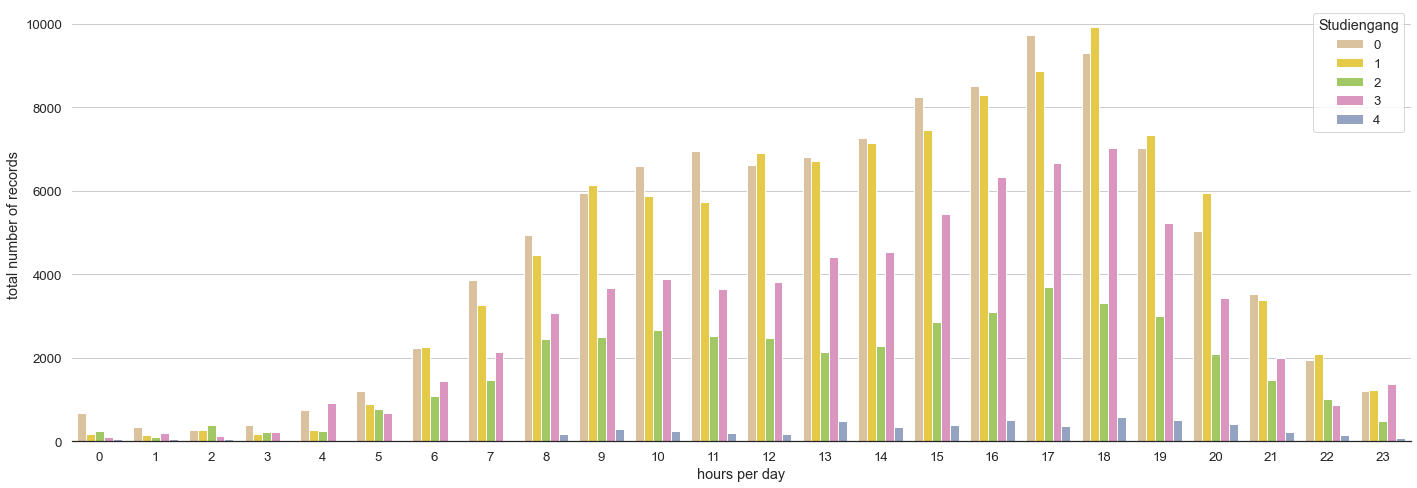

In [10755]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 8)) # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge pro Tagesstunde und Studiengang
chart = sns.countplot(x=hours_per_day, hue=moodle_data.Studiengang, hue_order=['0', '1', '2', '3', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Menge der Log-Einträge über alle Tagesstunden**

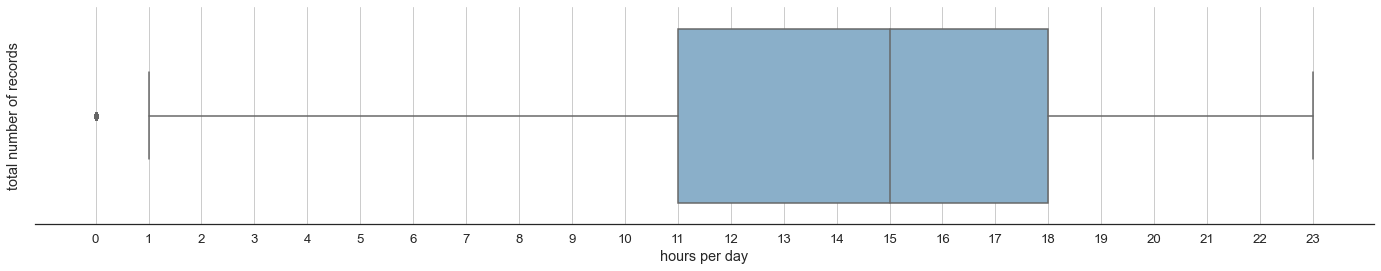

In [10756]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über alle Tagesstunden
chart = sns.boxplot(x=hours_per_day, orient='h', color=colors_general[4])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('total number of records')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Die Benutzeraktivitäten orientierten sich weitgehend an einem normalen Arbeitstag, die Hälfte aller Interaktionen wurden im Zeitraum von 11 bis 19 Uhr verzeichnet. Vor 9 Uhr wurden vergleichsweise nur wenig Aktivitäten festgestellt. Ab 19 Uhr nahm die Menge an protokollierten Interaktionen überraschenderweise deutlich ab.

&nbsp;
**Menge der Log-Einträge pro Student und Tagesstunde**
Betrachtet wird nur an wie vielen einzelnen Tagesstunden ein Student aktiv war und nicht wie lange ein Student insgesamt in Stunden bemessen aktiv war.

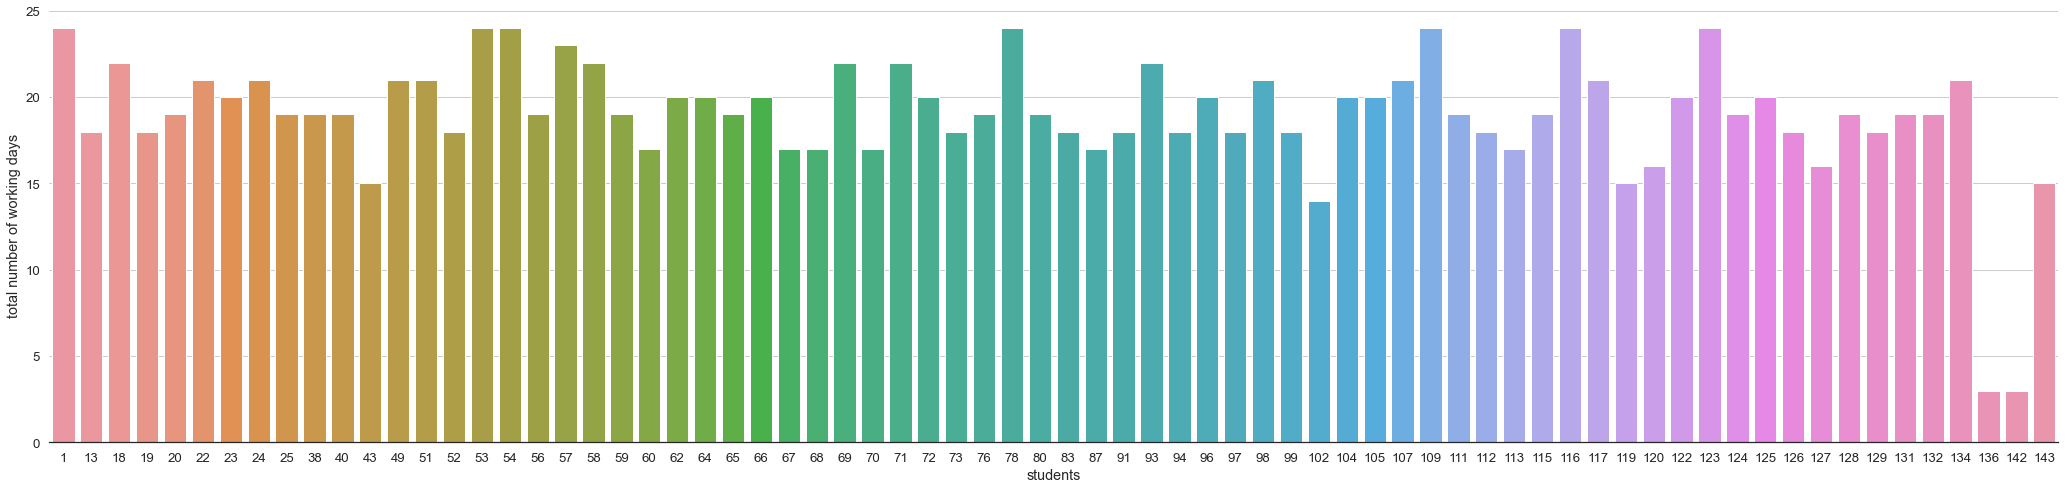

In [10757]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 8))  # Größe der Visualisierung (in inch)

# Ermittlung der Menge der Arbeitstage pro Student
result = moodle_data.timecreated.dt.hour.groupby(moodle_data.userid[moodle_data.userstatus == 'student']).nunique()
# Visualisierung der Menge der Arbeitstage pro Student
chart = sns.barplot(x=result.index.astype(int), y=result)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_xlabel('students')
chart.set_ylabel('total number of working days')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Auch wenn die Aktivitäten über den Tag sich im westentlichen auf die normalen Arbeitszeiten konzentrieren, so waren die allermeisten Studenten im Durchschnitt über den ganzen Tag verteilt aktiv.

&nbsp;
**Menge der Log-Einträge über alle Tagesstunden pro Studiengang**

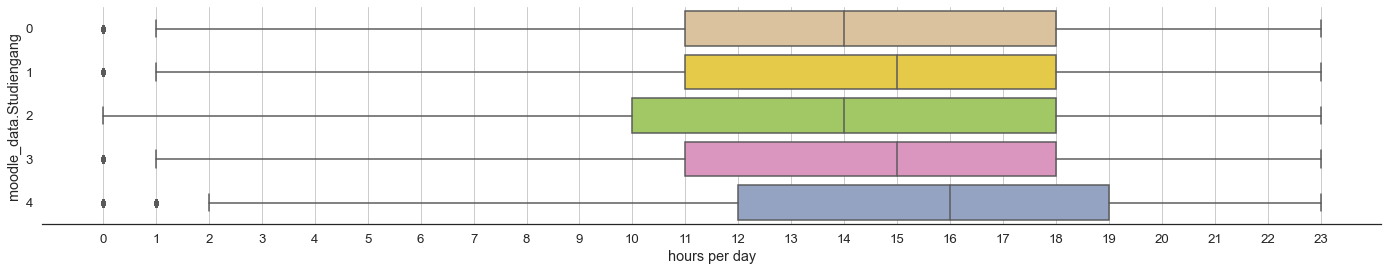

In [10758]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(24, 4))  # Größe der Visualisierung (in inch)

# Visualisierung der Menge der Log-Einträge über alle Tagesstunden pro Studiengang
chart = sns.boxplot(x=hours_per_day, y=moodle_data.Studiengang, order=['0', '1', '2', '3', '4'])
# nur für bestimmte Studiengänge
# chart = chart = sns.boxplot(x=hours_per_day, y=moodle_data.Studiengang, order=['0', '4'])

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='x')
chart.xaxis.set_ticks(range(0, 24, 1))
chart.set_xlabel('hours per day')
chart.set_ylabel('moodle_data.Studiengang')
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

&nbsp;
**Anteilige Mengen von Log-Einträgen pro Student und Tageszeit**

In [10759]:
# Ermittlung der absoluten Mengen an Log-Einträgen pro Student und Tageszeit
loggings = pd.DataFrame()
loggings['total'] = moodle_data.daytime[moodle_data.userstatus == 'student'].groupby(moodle_data.userid).count()
loggings['night'] = moodle_data.daytime[(moodle_data.userstatus == 'student') & (moodle_data.daytime == 'night')].groupby(moodle_data.userid).count()
loggings['morning'] = moodle_data.daytime[(moodle_data.userstatus == 'student') & (moodle_data.daytime == 'morning')].groupby(moodle_data.userid).count()
loggings['afternoon'] = moodle_data.daytime[(moodle_data.userstatus == 'student') & (moodle_data.daytime == 'afternoon')].groupby(moodle_data.userid).count()
loggings['evening'] = moodle_data.daytime[(moodle_data.userstatus == 'student') & (moodle_data.daytime == 'evening')].groupby(moodle_data.userid).count()
loggings.fillna(value=0, inplace=True)

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student und Tageszeit
# Aus Darstellungsgründen werden die anteiligen Mengen aufsummiert
loggings['morning'] = [i / j * 100 for i, j in zip(loggings['morning'], loggings['total'])]
# loggings['afternoon'] = [i / j * 100 for i, j in zip(loggings['afternoon'], loggings['total'])] # nicht aufsummiert
loggings['afternoon'] = [i / j * 100 + k for i, j, k in zip(loggings['afternoon'], loggings['total'], loggings['morning'])] # aufsummiert
# loggings['evening'] = [i / j * 100 for i, j in zip(loggings['evening'], loggings['total'])] # nicht aufsummiert
loggings['evening'] = [i / j * 100 + k for i, j, k in zip(loggings['evening'], loggings['total'], loggings['afternoon'])] # aufsummiert

# Ermittlung der anteiligen Mengen an Log-Einträgen pro Student (hier jeweils 100%)
loggings['total'] = [i / j * 100 for i,j in zip(loggings['total'], loggings['total'])]

display(loggings)

,total,night,morning,afternoon,evening
userid,,,,,
1,100.0,231.0,30.349288,77.981889,94.023286
13,100.0,6.0,35.450346,75.173210,99.861432
18,100.0,76.0,46.865521,81.445905,96.157735
19,100.0,25.0,43.259488,63.523957,99.570668
20,100.0,55.0,43.966830,86.833644,99.069216
...,...,...,...,...,...
132,100.0,42.0,45.072318,80.827447,98.587286
134,100.0,52.0,28.775113,73.644416,98.876647
136,100.0,0.0,90.909091,100.000000,100.000000


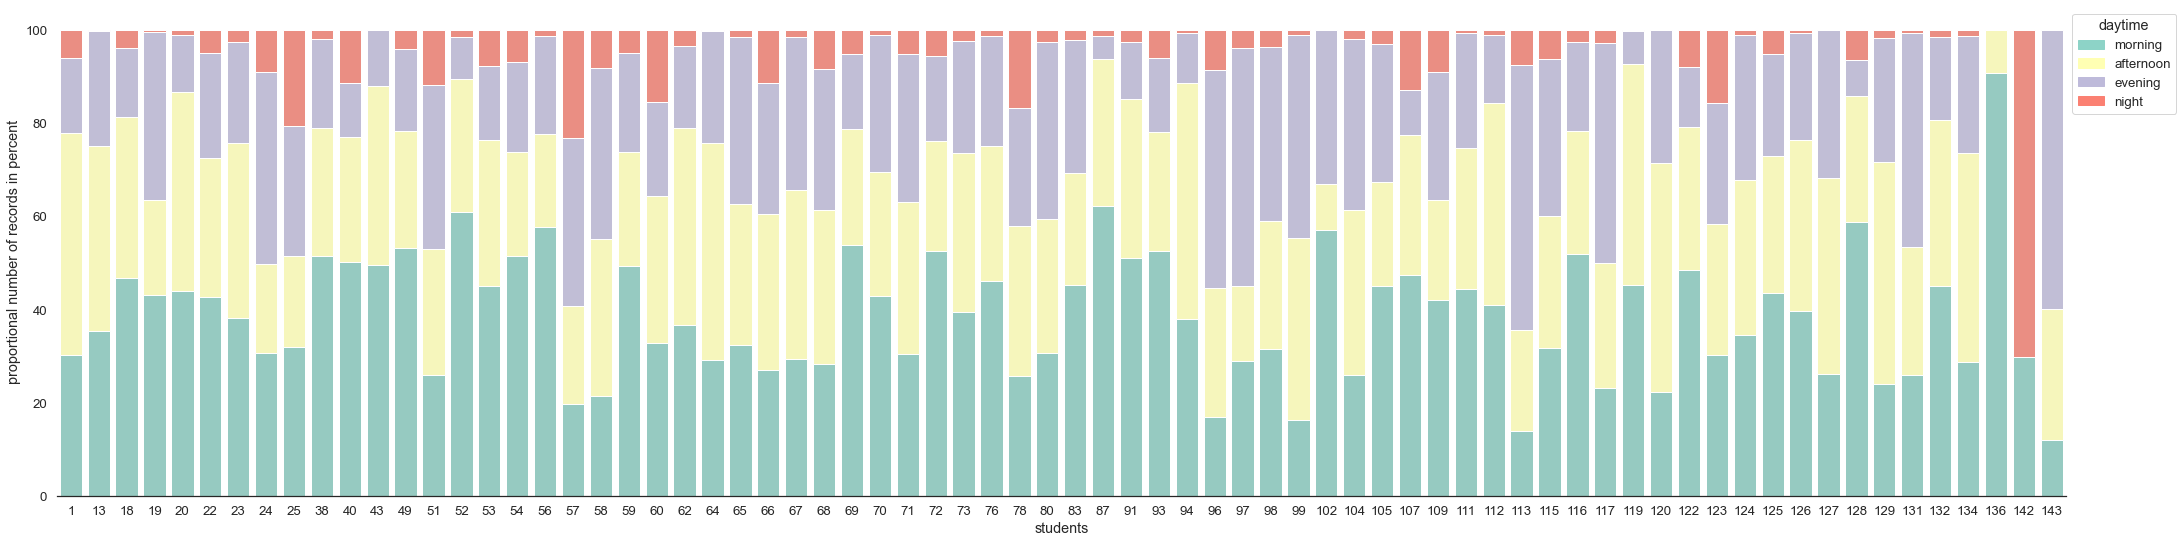

In [10760]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9))  # Größe der Visualisierung (in inch)

# Visualisierung der Gesamtmengen von Log-Einträgen pro Student und Tageszeit (in 100%)
bar_total = sns.barplot(x=loggings.index, y='total', data=loggings, color=colors_general[3], alpha=1)
# Visualisierung der anteiligen Mengen von Log-Einträgen pro Student und Tagestyp (in x%)
bar_evening = sns.barplot(x=loggings.index, y='evening', data=loggings, color=colors_general[2], alpha=1)
bar_afternoon = sns.barplot(x=loggings.index, y='afternoon', data=loggings, color=colors_general[1], alpha=1)
bar_morning = sns.barplot(x=loggings.index, y='morning', data=loggings, color=colors_general[0], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
bar1 = mpatches.Patch(color=colors_general[0], label='morning')
bar2 = mpatches.Patch(color=colors_general[1], label='afternoon')
bar3 = mpatches.Patch(color=colors_general[2], label='evening')
bar4 = mpatches.Patch(color=colors_general[3], label='night')
bar_total.set_xlabel('students')
bar_total.set_ylabel('proportional number of records in percent')
plt.legend(title='daytime', handles=[bar1, bar2, bar3, bar4], bbox_to_anchor=(1, 1))
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()

**Anmerkung:** Diese und auch die nachfolgende Visualisierung zeigen noch einmal deutlich, dass die Studenten überwiegend zu normalen Arbeitszeiten aktiv waren.

&nbsp;
**Absolute Mengen von Log-Einträgen pro Student und Tageszeit**

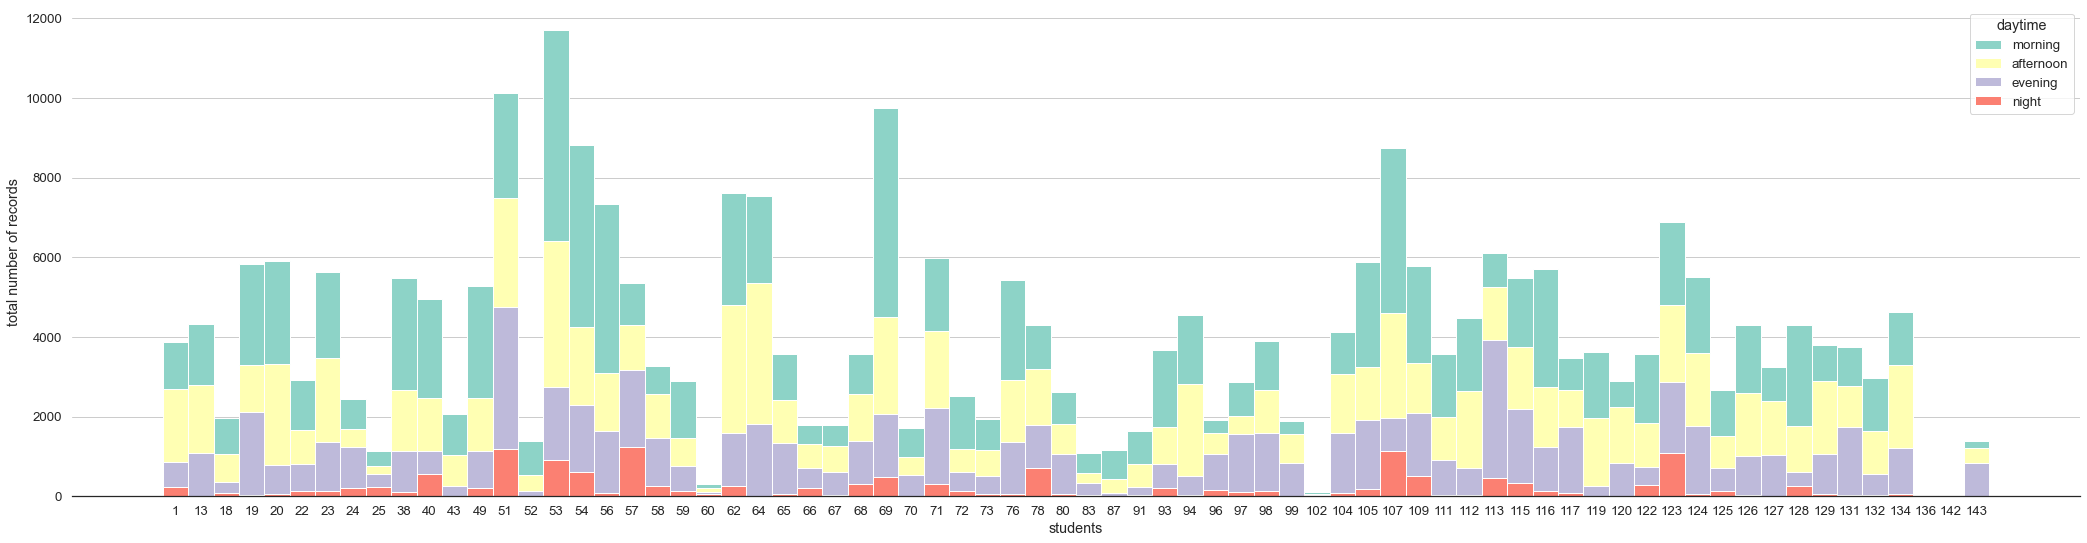

In [10761]:
# Spezifische Definitionen zur Darstellung der Visualisierung
plt.figure(figsize=(36, 9)) # Größe der Visualisierung (in inch)

# Visualisierung der absoluten Mengen von Log-Einträgen pro Student und Tageszeit
chart = sns.histplot(x=moodle_data.userid[moodle_data.userstatus == 'student'].astype(str), hue=moodle_data.daytime, hue_order=['morning', 'afternoon', 'evening', 'night'], multiple="stack", palette=colors_general[0:4], alpha=1)

# weitere Anweisungen zur Darstellung der Visualisierung
chart.grid(axis='y')
chart.set_axisbelow(True)
chart.set_xlabel('students')
chart.set_ylabel('total number of records')
chart.tick_params(left=False, bottom=False)
sns.despine(left=True)
# plt.savefig('charts/###.pdf', format='pdf')
plt.show()